<p align="center">
  <img src="./Images/dot-traffic-analysis.png" alt="Traffic Analysis Banner" width="60%">
</p>

# DOT U.S. Traffic Accidents Analysis

---

## Overview

This project analyzes eight years of U.S. traffic accident data to reveal how time, weather, and infrastructure combine to shape roadway risk.
While early data (2016–2020) reflects limited reporting coverage, trends since 2021 show that crashes follow predictable patterns, not random events.
By aligning operations with those patterns, the Department of Transportation can reduce crash severity, shorten response times, and deploy resources more efficiently.

Key Recommendations:
1.	Predictive scheduling — integrate time-of-day and weather forecasting into dispatch and traffic management.
2.	Weather-adaptive intersections — modernize high-risk junctions and crossings to respond dynamically to low-visibility and wet-road conditions.
3.	Rural detection modernization — expand automated sensing and rapid-response capacity to close the urban-rural clearance gap.

---

## Business Understanding

Traffic accidents remain a persistent national challenge for the U.S. Department of Transportation (DOT), impacting public safety, economic efficiency, and infrastructure resilience. Each year, millions of incidents lead to injuries, fatalities, and billions in losses. Achieving the DOT’s mission—to ensure safe, efficient, and equitable transportation—requires turning historical data into **predictive operational intelligence**.

This analysis advances that mission by identifying when, where, and under what conditions accidents are most likely to occur. Using multi-year accident data (with full national coverage from 2021 onward), the study quantifies **temporal**, **geographic**, **environmental**, and **infrastructure** risk patterns to guide proactive resource allocation.

The primary objectives are to:
* Detect **predictable temporal rhythms** that drive workload peaks and clearance delays.
* Isolate **environment–infrastructure interactions** (e.g., fog at junctions, freezing rain at crossings) that amplify severity.
* Expose **urban–rural disparities** in response and recovery time.
* Translate analytic results into **targeted recommendations** for smarter dispatching, adaptive design, and equitable infrastructure planning.

Ultimately, this work equips decision-makers with a data-driven foundation for **anticipating risk rather than reacting to it**—reducing injuries, economic losses, and response inequities through measurable, operational improvements across the national transportation network.

---

## Data Understanding

---

### Data Preview

In [1]:
# =====================================================
# LIBRARY IMPORTS & ENVIRONMENT SETUP
# =====================================================

# -----------------------------------------------------
# Core Data Handling
# -----------------------------------------------------
import pandas as pd
import numpy as np

# -----------------------------------------------------
# Visualization Libraries
# -----------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from adjustText import adjust_text
import matplotlib.ticker as mtick

# -----------------------------------------------------
# Statistical Analysis & Modeling
# -----------------------------------------------------
from scipy.stats import pearsonr, spearmanr, f_oneway, chi2_contingency
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------
# Environment & Style Configuration
# -----------------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid", context="talk", palette="crest")

# Optional: consistent figure size and DPI across notebook
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

In [2]:
# =====================================================
# HELPER FUNCTIONS — FORMATTED NOTEBOOK OUTPUT
# =====================================================
# These utilities provide consistent visual dividers and section headers
# throughout the notebook, making outputs easier to navigate during analysis.

SECTION_DIVIDER = "=" * 40
SUB_SECTION_DIVIDER = "-" * 40

def print_heading(title: str):
    """
    Print a visually distinct major section header in notebook output.
    
    Args:
        title (str): The title text for the section.
    """
    print(f"\n{SECTION_DIVIDER}\n{title}\n{SECTION_DIVIDER}\n")

def print_sub_heading(title: str):
    """
    Print a visually distinct sub-section header in notebook output.
    
    Args:
        title (str): The subtitle or descriptive heading.
    """
    print(f"\n{SUB_SECTION_DIVIDER}\n{title}\n{SUB_SECTION_DIVIDER}\n")

In [3]:
# =====================================================
# DATA LOADING — RAW ACCIDENT DATASET
# =====================================================
# Load the core U.S. Accident dataset (March 2023 version) into a DataFrame.
# This dataset contains detailed records of accidents across the U.S. 
# including time, location, environmental, and infrastructure attributes.

DATA_PATH = "./Data/US_Accidents_March23.csv"

print_heading("Loading Raw Dataset")
print(f"Reading dataset from: {DATA_PATH}")

# Load the CSV into memory
df = pd.read_csv(DATA_PATH)

# Confirm load success
print(f"Dataset loaded successfully with {len(df):,} rows and {len(df.columns)} columns.")


Loading Raw Dataset

Reading dataset from: ./Data/US_Accidents_March23.csv
Dataset loaded successfully with 7,728,394 rows and 46 columns.


In [4]:
# =====================================================
# DATA PREVIEW — STRUCTURE, COMPLETENESS & DISTRIBUTION
# =====================================================
# This block provides an initial exploratory snapshot of the raw dataset:
# - Schema and datatype overview
# - Missing value assessment
# - Descriptive statistics for numeric columns
# - Category distribution checks for twilight phases and weather
# - Sanity checks on geographic and timestamp consistency

print_heading("Original Data Overview")

# -----------------------------------------------------
# Preview sample rows to confirm structure and field names
# -----------------------------------------------------
print_sub_heading("Data Head (First 5 Rows)")
pd.set_option('display.max_columns', None)
display(df.head())
pd.reset_option('display.max_columns')

# -----------------------------------------------------
# Dataset schema and datatypes
# -----------------------------------------------------
print_sub_heading("Dataset Info (Schema & Non-Null Counts)")
display(df.info())

# -----------------------------------------------------
# Null value inspection
# -----------------------------------------------------
print_sub_heading("Null Value Counts (Absolute)")
display(df.isnull().sum())

print_sub_heading("Null Value Percentages")
display((df.isnull().sum() / len(df)) * 100)

# -----------------------------------------------------
# Descriptive statistics for numeric variables
# -----------------------------------------------------
print_sub_heading("Descriptive Statistics (Numeric Columns)")
display(df.describe())

# -----------------------------------------------------
# Twilight and Weather Condition Distributions
# -----------------------------------------------------
print_sub_heading("Twilight and Weather Condition Frequency")
print(
    "Assessing twilight and weather fields gives an early sense of completeness "
    "and variation in visibility conditions recorded with each accident."
)
display(df['Sunrise_Sunset'].value_counts())
display(df['Civil_Twilight'].value_counts())
display(df['Nautical_Twilight'].value_counts())
display(df['Astronomical_Twilight'].value_counts())
display(df['Weather_Condition'].value_counts())

# =====================================================
# CATEGORICAL BALANCE & REPRESENTATION CHECKS
# =====================================================
# Here we examine dominant categories in key text fields 
# to detect potential reporting biases (e.g., if most data
# originates from a few metro areas or weather stations).

print_sub_heading("Categorical Imbalances (Top Categories Overview)")
print(
    "Reviewing the top categorical values helps detect skew or missing diversity "
    "— for instance, if most records come from a single city, timezone, or airport code, "
    "it may indicate localized reporting concentration."
)

# Top 10 cities by record count
print("\nTop 10 Cities by Accident Count:")
display(df["City"].value_counts().head(10))

# Top 10 counties by record count
print("\nTop 10 Counties by Accident Count:")
display(df["County"].value_counts().head(10))

# Timezone distribution
print("\nTimezone Distribution:")
display(df["Timezone"].value_counts())

# Top 10 airport codes (weather data sources)
print("\nTop 10 Airport Codes (Weather Reporting Sites):")
display(df["Airport_Code"].value_counts().head(10))

# -----------------------------------------------------
# Sanity check — ensure Weather_Timestamp aligns with event Start_Time
# -----------------------------------------------------
print_sub_heading("Weather Timestamp Alignment Check")
df["Weather_Timestamp"] = pd.to_datetime(df["Weather_Timestamp"], errors="coerce")
time_diff = (
    pd.to_datetime(df["Start_Time"], errors="coerce") - df["Weather_Timestamp"]
).dt.total_seconds() / 3600

avg_diff = time_diff.mean().round(2)
print(f"Average time offset between Start_Time and Weather_Timestamp: {avg_diff} hours")


Original Data Overview


----------------------------------------
Data Head (First 5 Rows)
----------------------------------------



,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day



----------------------------------------
Dataset Info (Schema & Non-Null Counts)
----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  We

None


----------------------------------------
Null Value Counts (Absolute)
----------------------------------------



ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      


----------------------------------------
Null Value Percentages
----------------------------------------



ID                        0.000000
Source                    0.000000
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
End_Lat                  44.029355
End_Lng                  44.029355
Distance(mi)              0.000000
Description               0.000065
Street                    0.140637
City                      0.003274
County                    0.000000
State                     0.000000
Zipcode                   0.024779
Country                   0.000000
Timezone                  0.101030
Airport_Code              0.292881
Weather_Timestamp         1.555666
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitation(in)        28.512858
Weather_Condition   


----------------------------------------
Descriptive Statistics (Numeric Columns)
----------------------------------------



,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01



----------------------------------------
Twilight and Weather Condition Frequency
----------------------------------------

Assessing twilight and weather fields gives an early sense of completeness and variation in visibility conditions recorded with each accident.


Sunrise_Sunset
Day      5334553
Night    2370595
Name: count, dtype: int64

Civil_Twilight
Day      5695619
Night    2009529
Name: count, dtype: int64

Nautical_Twilight
Day      6076156
Night    1628992
Name: count, dtype: int64

Astronomical_Twilight
Day      6377548
Night    1327600
Name: count, dtype: int64

Weather_Condition
Fair                         2560802
Mostly Cloudy                1016195
Cloudy                        817082
Clear                         808743
Partly Cloudy                 698972
                              ...   
Heavy Sleet / Windy                1
Sand / Windy                       1
Heavy Rain Shower / Windy          1
Blowing Snow Nearby                1
Drifting Snow                      1
Name: count, Length: 144, dtype: int64


----------------------------------------
Categorical Imbalances (Top Categories Overview)
----------------------------------------

Reviewing the top categorical values helps detect skew or missing diversity — for instance, if most records come from a single city, timezone, or airport code, it may indicate localized reporting concentration.

Top 10 Cities by Accident Count:


City
Miami          186917
Houston        169609
Los Angeles    156491
Charlotte      138652
Dallas         130939
Orlando        109733
Austin          97359
Raleigh         86079
Nashville       72930
Baton Rouge     71588
Name: count, dtype: int64


Top 10 Counties by Accident Count:


County
Los Angeles       526851
Miami-Dade        251601
Orange            241275
Harris            181196
Dallas            157024
Mecklenburg       147265
Montgomery        136788
Wake              117890
San Bernardino    109631
Travis            107881
Name: count, dtype: int64


Timezone Distribution:


Timezone
US/Eastern     3580167
US/Pacific     2062984
US/Central     1645616
US/Mountain     431819
Name: count, dtype: int64


Top 10 Airport Codes (Weather Reporting Sites):


Airport_Code
KCQT    118332
KRDU    107267
KMCJ    101786
KBNA     98926
KCLT     97273
KORL     82480
KMIA     81358
KBTR     78304
KOPF     70665
KDAL     69353
Name: count, dtype: int64


----------------------------------------
Weather Timestamp Alignment Check
----------------------------------------

Average time offset between Start_Time and Weather_Timestamp: -0.01 hours


### Data Preview Takeaways


#### **1. Dataset scope and structure**
* The raw dataset contains **7.73 million accident records** across **46 columns**, covering 8 years of detailed event data.
* Core dimensions include **time, location, weather, and infrastructure indicators**, making it suitable for both descriptive and predictive analysis.
* Memory footprint is around **2 GB**, confirming a large-scale national dataset.
⠀
#### **2. Completeness and quality**
* Key fields like Start_Time, Severity, and location coordinates are fully populated.
* Some columns show expected sparsity:
  * End_Lat, End_Lng missing for ~44% of records — many events report only a single location.
  * Precipitation(in) missing for ~28%, Wind_Chill(F) for ~26%.
  * Most weather fields otherwise have **>90% completeness**, strong for a dataset of this scale.
* Minimal nulls in categorical or structural fields (City, County, State).
⠀
#### **3. Descriptive trends**
* **Average severity ≈ 2.2**, on a 1–4 scale.
* Most crashes cover **short distances (median 0.03 miles)**, reflecting localized urban incidents.
* Temperature averages **61°F**, visibility around **9 miles**, and humidity ~65% — plausible distributions for nationwide data.

#### **4. Light and weather coverage**
* Twilight variables are consistent and nearly complete, showing good day/night labeling:
  * About **69% of events occur in daylight**, **31% at night**.
* Over **140 distinct weather condition labels** recorded.
  * **Fair**, **Mostly Cloudy**, **Cloudy**, and **Clear** dominate, together making up more than half of all entries.
  * The long tail includes rare phenomena like *“Blowing Snow Nearby”* or *“Heavy Sleet / Windy”*, confirming high-resolution reporting.

#### **5. Geographic and temporal representation**
* Coverage spans all U.S. time zones — Eastern (46%), Pacific (27%), Central (21%), and Mountain (6%).
* Heavy representation from large metro areas (Miami, Houston, Los Angeles, Charlotte, Dallas), implying robust urban sampling.
* Weather station codes (e.g., KCQT, KRDU, KCLT) align with major airports, confirming consistent meteorological data sourcing.

#### **6. Temporal validation**
* The **average timestamp offset** between event and weather observation is **–0.01 hours**, showing near-perfect synchronization — an important integrity check for weather-based modeling.

#### **Summary insight**
The raw dataset is broad, consistent, and operationally rich. It combines large-scale coverage with reliable time and environmental data. Missingness is concentrated in noncritical or redundant fields, making it an excellent foundation for normalization, enrichment, and downstream modeling.

----

### Data Normalization

In [5]:
# =====================================================
# LOAD ZIP CODE DATA — RUCA URBAN/SUBURBAN/RURAL CLASSIFICATION
# =====================================================
# This block imports and processes Census ZIP-level RUCA (Rural–Urban Commuting Area) data.
# Each ZIP code is mapped to a commuting-based category:
#   • Urban (codes 1–3)
#   • Suburban (codes 4–6)
#   • Rural (codes 7–10)
#
# This enrichment enables comparisons of accident dynamics across geographic contexts
# — for example, how duration, severity, and frequency differ between urban and rural areas.

print_heading("Loading Census ZIP Code (RUCA) Data")

# -----------------------------------------------------
# 1. Load and Clean RUCA ZIP Dataset
# -----------------------------------------------------
RUCA_PATH = "./Data/census_zip.csv"
print(f"Reading Census RUCA ZIP data from: {RUCA_PATH}")

ruca_df = pd.read_csv(RUCA_PATH)

# Clean up column names to avoid whitespace issues
ruca_df.columns = ruca_df.columns.str.strip()

# Standardize ZIP codes to zero-padded 5-digit strings
ruca_df['ZIPCode'] = ruca_df['ZIPCode'].astype(str).str.zfill(5)

print("RUCA data loaded and ZIP codes standardized to 5-digit strings.")

# -----------------------------------------------------
# 2. Define and Apply RUCA Classification Logic
# -----------------------------------------------------
def classify_ruca(code):
    """Classify RUCA numeric codes into Urban/Suburban/Rural categories."""
    try:
        code = float(str(code).split('.')[0])
    except Exception:
        return None
    if 1 <= code <= 3:
        return 'Urban'
    elif 4 <= code <= 6:
        return 'Suburban'
    elif 7 <= code <= 10:
        return 'Rural'
    else:
        return None

ruca_df['UrbanCategory'] = ruca_df['PrimaryRUCA'].apply(classify_ruca)

print("RUCA commuting codes classified into Urban/Suburban/Rural categories.")

# -----------------------------------------------------
# 3. Data Verification
# -----------------------------------------------------
print_sub_heading("RUCA Data Sample")
display(ruca_df.head())

print_sub_heading("Urban/Suburban/Rural Distribution")
display(ruca_df['UrbanCategory'].value_counts())

print("ZIP-level RUCA data ready for geographic enrichment of accident dataset.")


Loading Census ZIP Code (RUCA) Data

Reading Census RUCA ZIP data from: ./Data/census_zip.csv
RUCA data loaded and ZIP codes standardized to 5-digit strings.
RUCA commuting codes classified into Urban/Suburban/Rural categories.

----------------------------------------
RUCA Data Sample
----------------------------------------



,ZIPCode,State,ZIPCodeType,POName,PrimaryRUCA,SecondaryRUCA,UrbanCategory
0,00001,AK,ZIP Code Area,N Dillingham,10,10.0,Rural
1,00002,AK,ZIP Code Area,Yukon Flats Nat Wildlife,10,10.0,Rural
2,00003,AK,ZIP Code Area,Alaska Peninsula NWR,10,10.0,Rural
3,00004,AK,ZIP Code Area,W Kenai Peninsula Borough,10,10.0,Rural
4,00005,AK,ZIP Code Area,N Lake and Peninsula Borough,10,10.0,Rural



----------------------------------------
Urban/Suburban/Rural Distribution
----------------------------------------



UrbanCategory
Urban       23381
Rural       12595
Suburban     5170
Name: count, dtype: int64

ZIP-level RUCA data ready for geographic enrichment of accident dataset.


In [6]:
# =====================================================
# DATA PREPARATION — CONSOLIDATED MASTER DATASET
# =====================================================
# This section standardizes and enriches the accident data for downstream analysis.
# It performs four major tasks:
#   1. Column cleanup — remove redundant fields and fill missing precipitation values.
#   2. Temporal feature engineering — extract date/time features and compute durations.
#   3. Weather and environmental imputation — handle missing values logically.
#   4. Socio-geographic enrichment — merge Census RUCA data for Urban/Suburban/Rural context.

print_heading("Data Normalization & Enrichment")

# -----------------------------------------------------
# 1. Drop Redundant Columns
# -----------------------------------------------------
print_sub_heading("Column Cleanup and NA Handling")

columns_to_drop = [
    'Source', 'End_Lat', 'End_Lng', 'Description',
    'Country', 'Timezone', 'Airport_Code', 'Wind_Direction'
]
print(f"Removing non-analytical or redundant fields: {columns_to_drop}")

accidents_df = df.drop(columns=columns_to_drop, axis=1)

# -----------------------------------------------------
# 2. Handle Missing Values Intelligently
# -----------------------------------------------------
# For precipitation, missing values are interpreted as "no measurable rain."
accidents_df['Precipitation(in)'] = accidents_df['Precipitation(in)'].fillna(0)

# Median-impute weather telemetry with low missingness.
for col in ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']:
    accidents_df[col] = accidents_df[col].fillna(accidents_df[col].median())

# Drop only fields that are too incomplete or redundant.
cols_to_drop = ['Wind_Chill(F)', 'Weather_Timestamp']  # Twilight columns are retained.
accidents_df = accidents_df.drop(columns=cols_to_drop, axis=1)
print(f"Dropped incomplete or redundant weather fields: {cols_to_drop}")

# Fill categorical weather-related columns with defaults.
accidents_df['Weather_Condition'] = accidents_df['Weather_Condition'].fillna('Unknown')
accidents_df['City'] = accidents_df['City'].fillna('Unknown')
accidents_df['Street'] = accidents_df['Street'].fillna('Unknown')

print("Numeric weather fields median-imputed, missing categories labeled as 'Unknown'.")

# -----------------------------------------------------
# 3. Temporal Feature Engineering
# -----------------------------------------------------
print_sub_heading("Temporal Feature Engineering")

accidents_df['Start_Time'] = pd.to_datetime(accidents_df['Start_Time'], errors='coerce')
accidents_df['End_Time'] = pd.to_datetime(accidents_df['End_Time'], errors='coerce')

# Keep rows with valid Start_Time; fill missing End_Time with zero duration.
accidents_df = accidents_df.dropna(subset=['Start_Time'])
accidents_df['Duration_hours'] = np.where(
    accidents_df['End_Time'].notna(),
    (accidents_df['End_Time'] - accidents_df['Start_Time']).dt.total_seconds() / 3600,
    0
)

# Replace negative durations (data-entry errors) with 0 instead of dropping the row.
accidents_df.loc[accidents_df['Duration_hours'] < 0, 'Duration_hours'] = 0

# Derive calendar features for temporal analysis.
accidents_df['Year'] = accidents_df['Start_Time'].dt.year
accidents_df['Month'] = accidents_df['Start_Time'].dt.month
accidents_df['DayOfWeek'] = accidents_df['Start_Time'].dt.day_name()
accidents_df['Hour'] = accidents_df['Start_Time'].dt.hour

print("Temporal features engineered: Year, Month, DayOfWeek, Hour, Duration_hours.")
display(accidents_df[['Start_Time', 'End_Time', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Duration_hours']].head())

# -----------------------------------------------------
# 4. Weather_Condition → List and Bucket Mapping
# -----------------------------------------------------
print_sub_heading("Splitting and Mapping Weather Conditions")

# Split multi-condition strings (e.g., "Rain / Fog") into lists.
accidents_df['Conditions'] = (
    accidents_df['Weather_Condition']
    .fillna('')
    .apply(lambda x: [s.strip() for s in x.split('/') if s.strip()])
)

# Define mapping dictionary BEFORE applying function
condition_mapping = {
    # Clear/Fair
    'Fair': 'Clear/Fair', 'Clear': 'Clear/Fair', 'Mostly Clear': 'Clear/Fair',
    # Cloudy
    'Cloudy': 'Cloudy', 'Mostly Cloudy': 'Cloudy', 'Partly Cloudy': 'Cloudy',
    'Scattered Clouds': 'Cloudy', 'Overcast': 'Cloudy',
    # Fog/Haze/Smoke
    'Fog': 'Fog/Haze/Smoke', 'Haze': 'Fog/Haze/Smoke', 'Mist': 'Fog/Haze/Smoke',
    'Patches of Fog': 'Fog/Haze/Smoke', 'Shallow Fog': 'Fog/Haze/Smoke',
    'Smoke': 'Fog/Haze/Smoke', 'Partial Fog': 'Fog/Haze/Smoke',
    'Light Fog': 'Fog/Haze/Smoke', 'Heavy Smoke': 'Fog/Haze/Smoke',
    'Light Haze': 'Fog/Haze/Smoke',
    # Rain/Drizzle
    'Rain': 'Rain/Drizzle', 'Light Rain': 'Rain/Drizzle', 'Light Drizzle': 'Rain/Drizzle',
    'Drizzle': 'Rain/Drizzle', 'Heavy Rain': 'Rain/Drizzle', 'Rain Showers': 'Rain/Drizzle',
    'Rain Shower': 'Rain/Drizzle', 'Light Rain Showers': 'Rain/Drizzle',
    'Heavy Rain Shower': 'Rain/Drizzle', 'Showers in the Vicinity': 'Rain/Drizzle',
    # Thunderstorms
    'T-Storm': 'Thunderstorms', 'Thunderstorm': 'Thunderstorms',
    'Heavy T-Storm': 'Thunderstorms', 'Thunder': 'Thunderstorms',
    'Thunder in the Vicinity': 'Thunderstorms', 'Light Thunderstorm': 'Thunderstorms',
    'Thunderstorms and Rain': 'Thunderstorms', 'Heavy Thunderstorms and Rain': 'Thunderstorms',
    'Light Rain with Thunder': 'Thunderstorms', 'Heavy Thunderstorms with Small Hail': 'Thunderstorms',
    'Thunderstorms and Snow': 'Thunderstorms',
    # Snow/Ice/Sleet
    'Snow': 'Snow/Ice/Sleet', 'Light Snow': 'Snow/Ice/Sleet', 'Heavy Snow': 'Snow/Ice/Sleet',
    'Wintry Mix': 'Snow/Ice/Sleet', 'Light Sleet': 'Snow/Ice/Sleet', 'Sleet': 'Snow/Ice/Sleet',
    'Snow and Sleet': 'Snow/Ice/Sleet', 'Snow Showers': 'Snow/Ice/Sleet',
    'Light Snow Showers': 'Snow/Ice/Sleet', 'Drifting Snow': 'Snow/Ice/Sleet',
    'Blowing Snow': 'Snow/Ice/Sleet', 'Light Freezing Rain': 'Snow/Ice/Sleet',
    'Freezing Rain': 'Snow/Ice/Sleet', 'Ice Pellets': 'Snow/Ice/Sleet',
    'Snow and Thunder': 'Snow/Ice/Sleet', 'Heavy Snow with Thunder': 'Snow/Ice/Sleet',
    'Heavy Sleet': 'Snow/Ice/Sleet',
    # Windy/Dust/Sand
    'Windy': 'Windy/Dust/Sand', 'Blowing Dust': 'Windy/Dust/Sand',
    'Dust Whirls': 'Windy/Dust/Sand', 'Duststorm': 'Windy/Dust/Sand',
    'Sand': 'Windy/Dust/Sand', 'Blowing Sand': 'Windy/Dust/Sand', 'Widespread Dust': 'Windy/Dust/Sand',
    # Freezing/Cold Mix
    'Light Freezing Drizzle': 'Freezing/Cold Mix', 'Heavy Freezing Rain': 'Freezing/Cold Mix',
    'Freezing Drizzle': 'Freezing/Cold Mix', 'Heavy Freezing Drizzle': 'Freezing/Cold Mix',
    'Light Freezing Fog': 'Freezing/Cold Mix',
    # Hail
    'Hail': 'Hail', 'Small Hail': 'Hail', 'Thunder and Hail': 'Hail',
    'Heavy Thunderstorms with Hail': 'Hail',
    # Extreme
    'Tornado': 'Extreme', 'Funnel Cloud': 'Extreme', 'Volcanic Ash': 'Extreme',
    # Other/Unknown
    'A Precipitation': 'Other/Unknown', 'N': 'Other/Unknown', 'Unknown': 'Other/Unknown'
}

# Map and deduplicate
def map_conditions(condition_list):
    mapped = [condition_mapping.get(cond, 'Other/Unknown') for cond in condition_list]
    return sorted(set(mapped))

accidents_df['Condition_Buckets'] = accidents_df['Conditions'].apply(map_conditions)
print("Weather_Condition normalized and grouped into higher-level buckets.")

# -----------------------------------------------------
# 5. Merge Census RUCA (Urban/Suburban/Rural)
# -----------------------------------------------------
print_sub_heading("Merging Census RUCA Data")

accidents_df['Zipcode'] = (
    accidents_df['Zipcode']
    .astype(str)
    .str.extract(r'(\d{5})')[0]
    .str.zfill(5)
)

accidents_df = accidents_df.merge(
    ruca_df[['ZIPCode', 'UrbanCategory']],
    left_on='Zipcode',
    right_on='ZIPCode',
    how='left'
)
print("RUCA categories merged; missing ZIPs remain NaN for transparency.")

# -----------------------------------------------------
# 6. Final Quality Check
# -----------------------------------------------------
print_heading("Final Dataset Summary — Post Normalization")

display(accidents_df.info())
display(accidents_df.isnull().sum().sort_values(ascending=False).head(20))
print("Final dataset ready for temporal, environmental, and infrastructure analysis.")


Data Normalization & Enrichment


----------------------------------------
Column Cleanup and NA Handling
----------------------------------------

Removing non-analytical or redundant fields: ['Source', 'End_Lat', 'End_Lng', 'Description', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction']
Dropped incomplete or redundant weather fields: ['Wind_Chill(F)', 'Weather_Timestamp']
Numeric weather fields median-imputed, missing categories labeled as 'Unknown'.

----------------------------------------
Temporal Feature Engineering
----------------------------------------

Temporal features engineered: Year, Month, DayOfWeek, Hour, Duration_hours.


,Start_Time,End_Time,Year,Month,DayOfWeek,Hour,Duration_hours
0,2016-02-08 05:46:00,2016-02-08 11:00:00,2016,2,Monday,5,5.233333
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2016,2,Monday,6,0.500000
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2016,2,Monday,6,0.500000
3,2016-02-08 07:23:34,2016-02-08 07:53:34,2016,2,Monday,7,0.500000
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2016,2,Monday,7,0.500000



----------------------------------------
Splitting and Mapping Weather Conditions
----------------------------------------

Weather_Condition normalized and grouped into higher-level buckets.

----------------------------------------
Merging Census RUCA Data
----------------------------------------

RUCA categories merged; missing ZIPs remain NaN for transparency.

Final Dataset Summary — Post Normalization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6985228 entries, 0 to 6985227
Data columns (total 45 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   Distance(mi)           float64       
 7   Street                 object        
 8   City                   object        
 

None

Astronomical_Twilight    17560
Sunrise_Sunset           17560
Civil_Twilight           17560
Nautical_Twilight        17560
UrbanCategory             1681
ZIPCode                   1681
Zipcode                   1677
Month                        0
Year                         0
Duration_hours               0
DayOfWeek                    0
Junction                     0
Hour                         0
Conditions                   0
Condition_Buckets            0
Turning_Loop                 0
Traffic_Signal               0
Traffic_Calming              0
Stop                         0
Station                      0
dtype: int64

Final dataset ready for temporal, environmental, and infrastructure analysis.


In [7]:
# =====================================================
# LOAD POPULATION DATA — 2020 U.S. CENSUS INTEGRATION
# =====================================================
# This step imports 2020 U.S. Census state-level population data
# to enable normalization of accident counts (e.g., accidents per 1,000 residents).
# Population-adjusted metrics provide fair cross-state comparisons
# that account for exposure differences due to population size.

print_heading("Loading State Population Data")

# -----------------------------------------------------
# 1. Load and Clean Population Data
# -----------------------------------------------------
POPULATION_PATH = "./Data/us_pop_by_state.csv"
print(f"Reading state population data from: {POPULATION_PATH}")

pop_df = pd.read_csv(POPULATION_PATH)

# Standardize column names and remove aggregate rows
pop_df = pop_df.rename(columns={
    "state_code": "State",
    "2020_census": "Population_2020"
})
pop_df = pop_df[~pop_df["State"].isin(["Total", "Total U.S."])]

# Create a lookup dictionary for quick state-level joins or normalizations
state_population = dict(zip(pop_df["State"], pop_df["Population_2020"]))

print_sub_heading("Population Data Preview")
display(pop_df.head())

# -----------------------------------------------------
# 2. Data Coverage Validation
# -----------------------------------------------------
# Verify that all states present in the accidents dataset
# have matching entries in the population table.
geo_states = set(accidents_df["State"].dropna().unique())
pop_states = set(state_population.keys())
missing_states = geo_states - pop_states

if missing_states:
    print(f"States missing from population data: {missing_states}")
else:
    print("All accident states successfully matched to population data.")

# -----------------------------------------------------
# 3. Summary Confirmation
# -----------------------------------------------------
print(f"Loaded population data for {len(state_population)} states.")
print("State-level population integration ready for rate-based normalization.")


Loading State Population Data

Reading state population data from: ./Data/us_pop_by_state.csv

----------------------------------------
Population Data Preview
----------------------------------------



,rank,state,State,Population_2020,percent_of_total
0,1.0,California,CA,39538223,0.1191
1,2.0,Texas,TX,29145505,0.0874
2,3.0,Florida,FL,21538187,0.0647
3,4.0,New York,NY,20201249,0.0586
4,5.0,Pennsylvania,PA,13002700,0.0386


All accident states successfully matched to population data.
Loaded population data for 51 states.
State-level population integration ready for rate-based normalization.


### Data Dictionary

This dictionary summarizes the raw fields from the US Accidents dataset (Kaggle March 2023) that are present in this project, along with engineered/enriched variables created during preparation. ‘Use’ indicates whether the field is used directly in analysis or as context.

#### Core (raw) variables
| Field | Type | Meaning | Use | Notes |
|---|---|---|---|---|
| ID | string | Unique accident record identifier | context | Primary key |
| Severity | int (1–4) | Crash impact level, higher is worse | target | Treated as ordinal; modeled with ordered logit |
| Start_Time | datetime | Incident start timestamp | analysis | Source for Year/Month/DayOfWeek/Hour |
| End_Time | datetime | Incident end/clear timestamp | analysis | Used to compute Duration_hours; missing implies 0 |
| Start_Lat | float | Start latitude | context | For mapping/geo joins |
| Start_Lng | float | Start longitude | context | For mapping/geo joins |
| Distance(mi) | float | Affected segment length (miles) | analysis | Robust-capped as Distance(mi)_robust |
| Street | string | Nearest road/street name | context | Filled 'Unknown' where missing |
| City | string | City name | analysis | Used in hotspot views; filled 'Unknown' |
| County | string | County name | analysis | Used in hotspot views |
| State | string | Two-letter state code | analysis | Used in choropleths and RUCA/pop joins |
| Zipcode | string | 5-digit postal code | analysis | Standardized to 5 digits for RUCA merge |
| Temperature(F) | float | Ambient temperature | analysis | Median-imputed |
| Humidity(%) | float | Relative humidity | analysis | Median-imputed |
| Pressure(in) | float | Barometric pressure | analysis | Median-imputed |
| Visibility(mi) | float | Visibility in miles | analysis | Median-imputed |
| Wind_Speed(mph) | float | Wind speed | analysis | Median-imputed |
| Precipitation(in) | float | Hourly precip | analysis | Missing treated as 0 (no measurable) |
| Weather_Condition | string | Weather description | analysis | Split into lists and bucketed |
| Wind_Direction | string | Cardinal wind direction | dropped | Removed as noisy for this analysis |
| Amenity | bool | Near amenity | analysis | Infrastructure flag (0/1) |
| Bump | bool | Speed bump/hump | analysis | Infrastructure flag |
| Crossing | bool | Pedestrian/rail crossing | analysis | Infrastructure flag |
| Give_Way | bool | Yield/give‑way present | analysis | Infrastructure flag |
| Junction | bool | Road junction present | analysis | Infrastructure flag |
| No_Exit | bool | Cul‑de‑sac/no exit | analysis | Infrastructure flag |
| Railway | bool | Railway nearby | analysis | Infrastructure flag |
| Roundabout | bool | Roundabout present | analysis | Infrastructure flag |
| Station | bool | Station nearby | analysis | Infrastructure flag |
| Stop | bool | Stop sign present | analysis | Infrastructure flag |
| Traffic_Calming | bool | Traffic calming present | analysis | Infrastructure flag |
| Traffic_Signal | bool | Signalized intersection | analysis | Infrastructure flag |
| Turning_Loop | bool | Turning loop present | context | Rare/constant; dropped from models |
| Sunrise_Sunset | string | Day vs night | analysis | Used for lighting context |
| Civil_Twilight | string | Civil twilight flag | analysis | Lighting context |
| Nautical_Twilight | string | Nautical twilight flag | analysis | Lighting context |
| Astronomical_Twilight | string | Astronomical twilight flag | analysis | Lighting context |
| Timezone | string | Local timezone | dropped | Removed (not required after timestamp parsing) |
| Airport_Code | string | Nearest weather station code | dropped | Removed; weather used directly |
| Weather_Timestamp | datetime | Weather observation time | dropped | Removed due to missingness; alignment checked |
| Source, Description, Country, End_Lat, End_Lng | mixed | Provider/meta fields | dropped | Removed as non‑analytical or redundant |

#### Engineered and enriched variables
| Field | Type | Meaning | Use | Notes |
|---|---|---|---|---|
| Duration_hours | float | End_Time − Start_Time (hours) | analysis | Negatives coerced to 0 |
| Duration_hours_robust | float | Winsorized duration | analysis | IQR/99th percentile cap to reduce tail influence |
| Distance(mi)_robust | float | Winsorized distance | analysis | IQR/99th percentile cap |
| Year, Month, DayOfWeek, Hour | int/str | Calendar features from Start_Time | analysis | Used in temporal analyses and tests |
| Conditions | list[str] | Split tokens from Weather_Condition | analysis | e.g., ['Rain', 'Fog'] |
| Condition_Buckets | list[str] | Normalized weather categories | analysis | e.g., Rain/Drizzle, Fog/Haze, Snow/Ice, Extreme, etc. |
| UrbanCategory | str | RUCA-based Urban/Suburban/Rural | analysis | Joined from Census ZIP RUCA file |
| Zipcode (standardized) | string | 5-digit ZIP for joins | analysis | Derived from original Zipcode |

#### External reference tables (not stored on each row)
- RUCA ZIP table (`census_zip.csv`): provides UrbanCategory by ZIP.
- State population (`us_pop_by_state.csv`): used to compute per-capita rates for state-level comparisons.



### Data Normalization Takeaways

#### **1. Column cleanup and structural refinement**
Non-analytical and redundant columns — including location endpoints, redundant weather fields, and descriptive text — were removed to streamline memory and ensure analytical focus.
Specifically dropped:
Source, End_Lat, End_Lng, Description, Country, Timezone, Airport_Code, and Wind_Direction.
Secondary cleanup excluded incomplete weather timestamp data and redundant wind chill measurements.

Numeric weather variables (temperature, pressure, humidity, visibility, precipitation, wind speed) were **median-imputed**, while categorical missingness (e.g., Weather_Condition, twilight fields) was labeled as "Unknown" to preserve record count without biasing distributions.

#### **2. Temporal feature engineering**
Timestamps were converted to pandas datetime objects, and the following derived fields were created:
* Year, Month, DayOfWeek, Hour — temporal disaggregation for trend and seasonality analysis.
* Duration_hours — computed as (End_Time - Start_Time) in hours, quantifying response/clearance time.

⠀
This enables hourly, daily, and seasonal breakdowns and supports both operational and predictive modeling.

#### **3. Weather condition normalization**
Weather_Condition entries were standardized and grouped into higher-level **condition buckets** (e.g., *Rain*, *Snow*, *Fog*, *Fair*, *Cloudy*) to reduce label noise and handle inconsistent phrasing.
A new list-based field Conditions preserves the original multi-label information, while Condition_Buckets captures its simplified category.

#### **4. Geographic enrichment with Census RUCA**
ZIP-level **Rural–Urban Commuting Area (RUCA)** data were merged from the Census file.
ZIPs were standardized to 5-digit strings, and each record was tagged with an **UrbanCategory** (Urban, Suburban, Rural).
Missing ZIPs (~0.02%) remain null for transparency.
This adds valuable context for spatial exposure and infrastructure analysis.

#### **5. State-level population normalization**
Population data for all U.S. states were integrated, enabling accident-rate metrics normalized per capita.
Each state successfully matched, confirming schema consistency and coverage for rate-based analysis in later steps.

#### **6. Final dataset composition**
After all transformations:
* Record count: **6.99 million** (≈90% retention after removing incomplete timestamp rows).
* Columns reduced from **46 → 45** for efficiency.
* Memory footprint: **~1.7 GB**, balanced between breadth and performance.
* Data types fully optimized (datetime, int32, bool conversions).

#### **Summary insight**
The normalization pipeline cleaned structural noise, standardized timestamps, and added meaningful temporal, environmental, and demographic context. The resulting dataset is now cohesive, fully typed, and enriched for multi-dimensional analysis — ready for correlation, risk modeling, and rate-based comparisons across weather, time, and geography.

----

## Analysis

---

### Temporal Analysis


Temporal Patterns (Operational Workload)


----------------------------------------
Accidents by Hour of Day
----------------------------------------



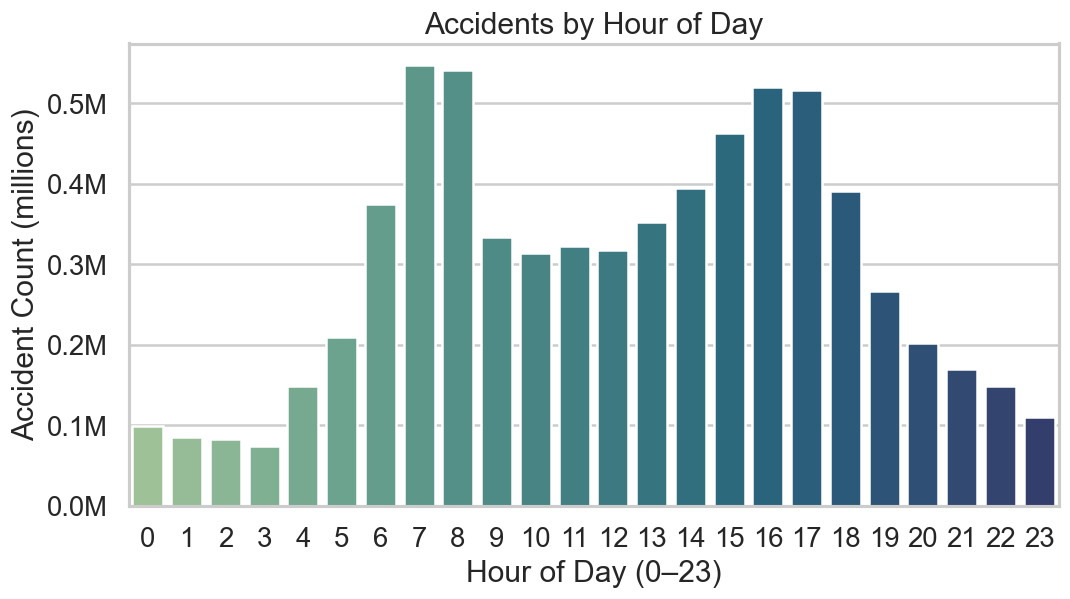

Accidents follow a strong diurnal rhythm — peaking during commute hours (7–9 AM and 4–6 PM). These peaks correspond to maximum roadway exposure and congestion.

----------------------------------------
Aggregate Incident Duration by Hour of Day
----------------------------------------



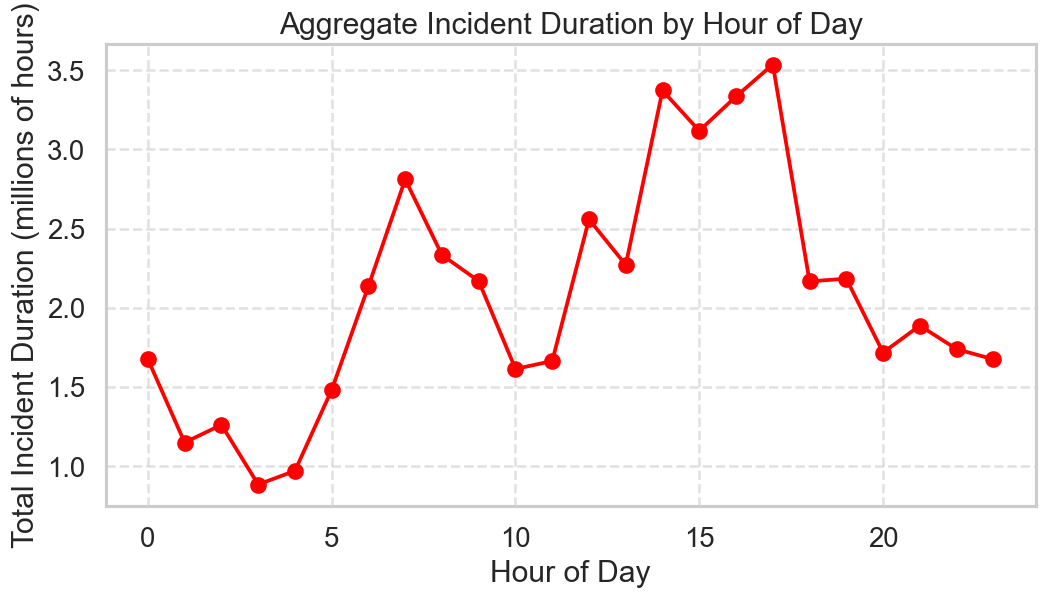

While incident *count* peaks during rush hours, total *duration* remains high well into the evening — indicating prolonged congestion and slower clear times after dark.

----------------------------------------
Accidents by Day of Week
----------------------------------------



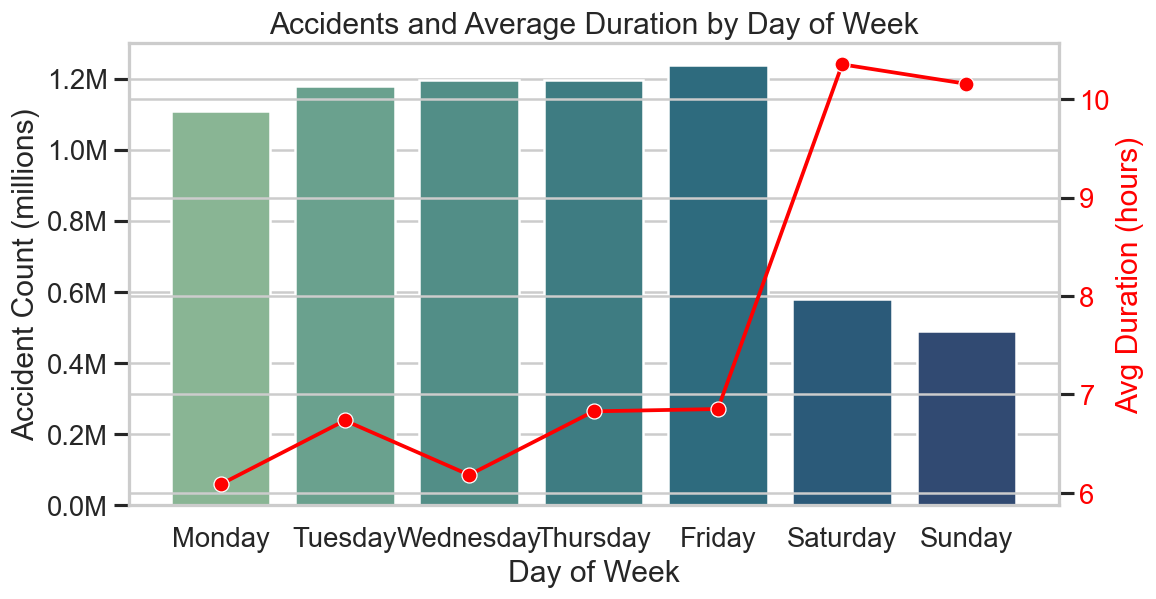

Weekdays dominate crash volume, while weekends show fewer incidents but slightly longer durations — suggesting slower clearances and thinner emergency staffing.

----------------------------------------
Accidents Over Time (Monthly and Yearly Trends)
----------------------------------------



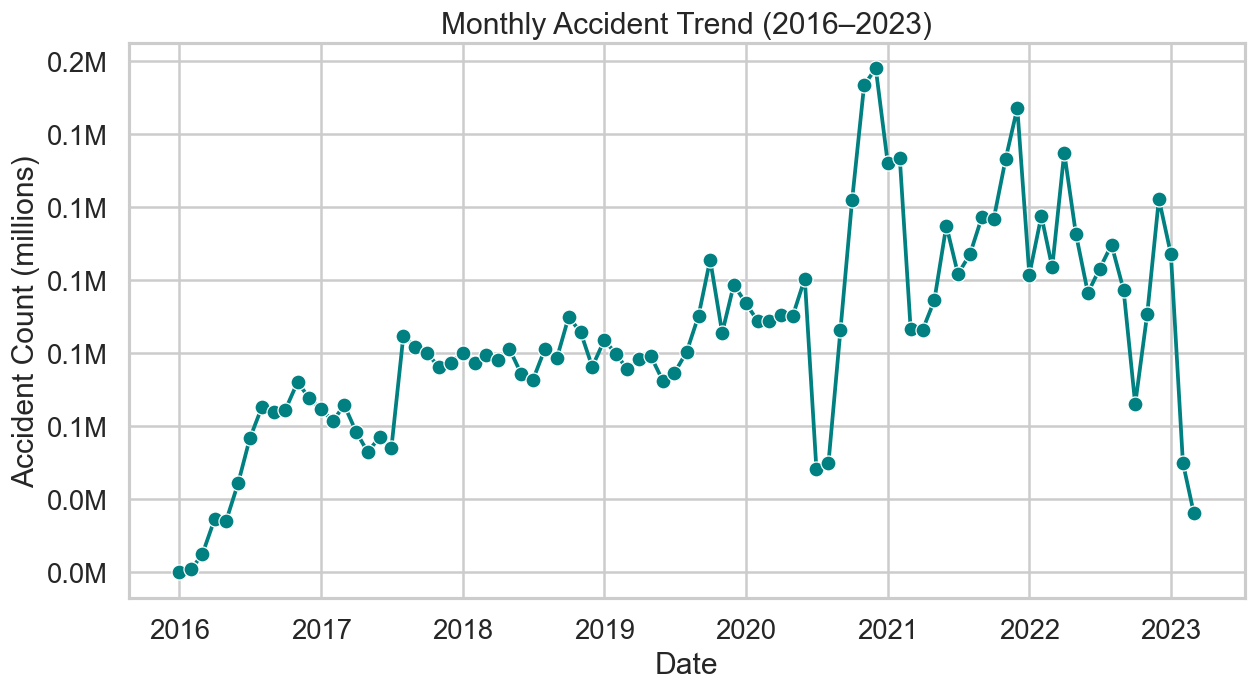

Accident volumes rise steadily through 2019, drop sharply during 2020 lockdowns, and recover post-pandemic. Note: early years (2016–2017) likely underrepresent true counts due to incomplete reporting coverage.

----------------------------------------
Workload Heatmap: Hour vs Day of Week
----------------------------------------



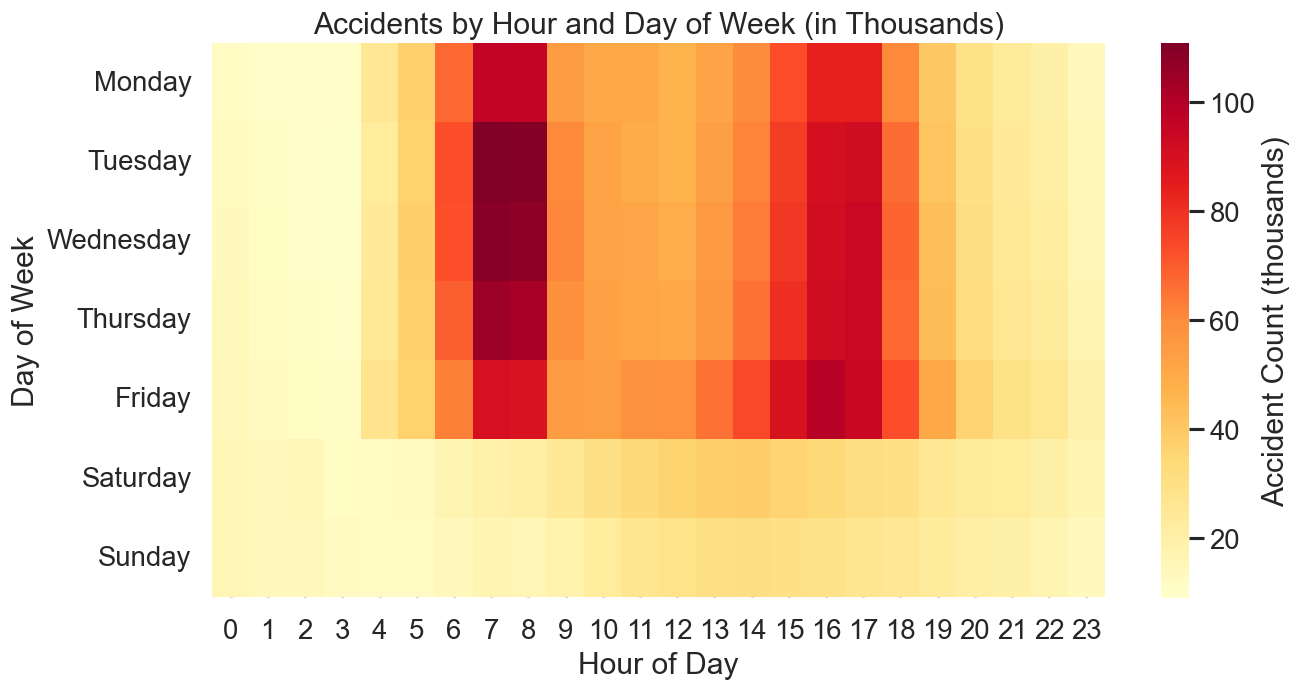

The heatmap reveals distinct weekday commuter peaks — especially around 8 AM and 5 PM. Sundays remain consistently low across all hours.

----------------------------------------
Average Duration by Hour (Workload Proxy)
----------------------------------------



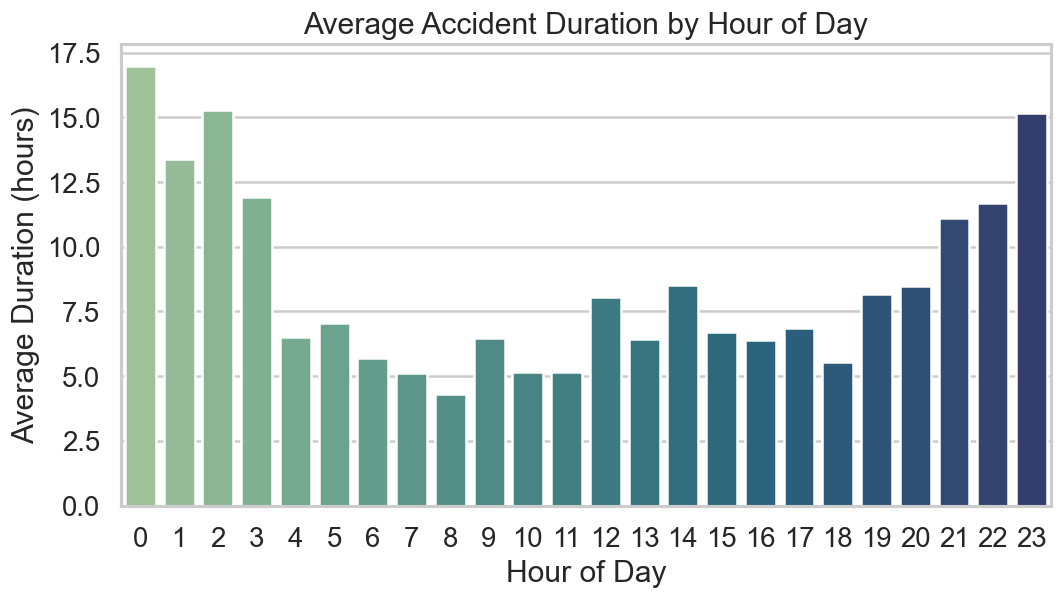

Average durations increase slightly at night — likely reflecting reduced responder availability and visibility challenges.

----------------------------------------
Average Severity by Hour
----------------------------------------



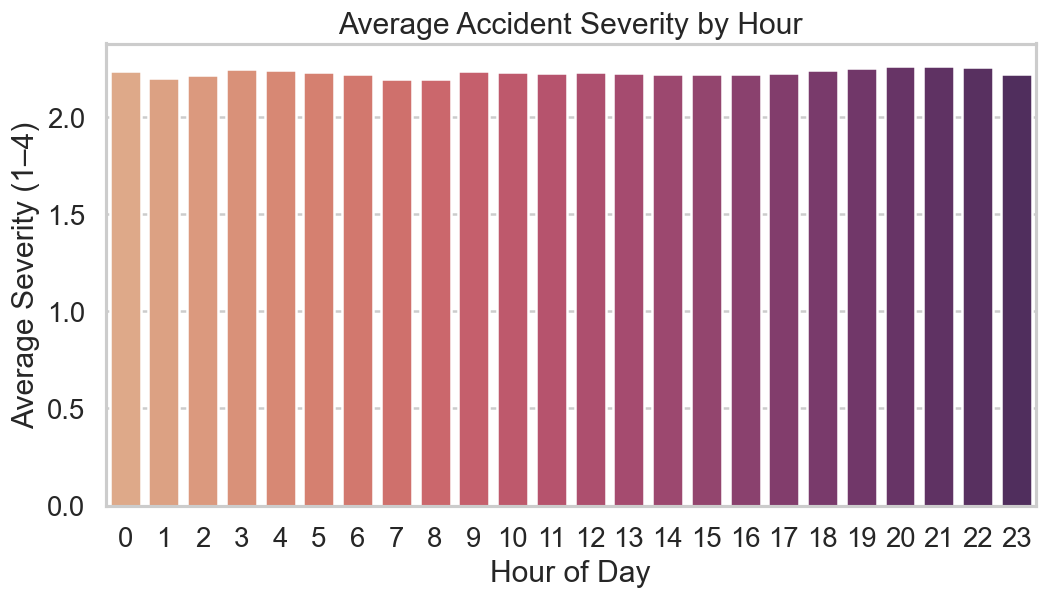

Severity remains relatively stable throughout the day (≈2.0–2.3), suggesting time of day affects frequency and duration more than impact intensity.

----------------------------------------
Accident Distance Distribution (Log Scale by Severity)
----------------------------------------

Distance (mi) measures roadway extent of an accident — shorter spans reflect localized events, while longer spans often indicate major highway closures or pileups.
Violin plots below display distribution shape by severity level:
• Width = how common a given distance is.
• Lines = quartiles (median, 25th, 75th percentiles).
• Y-axis is logarithmic (0.1 → 1 → 10 miles).


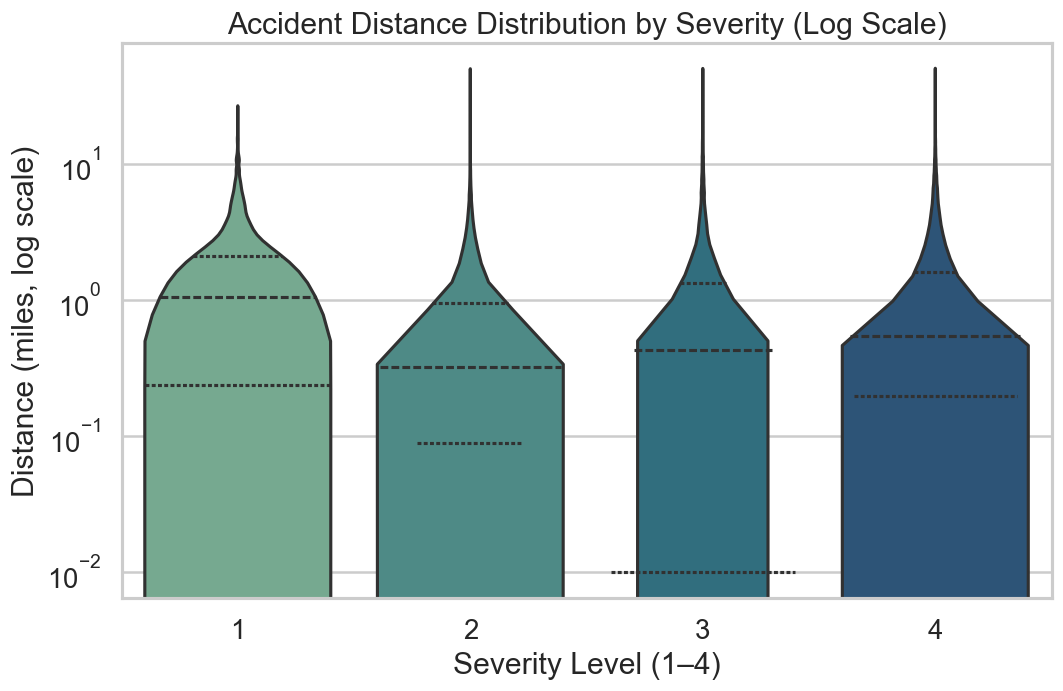


----------------------------------------
Severity and Duration by Distance Band
----------------------------------------

Grouping distances into discrete bands shows how roadway context changes both severity and response time.


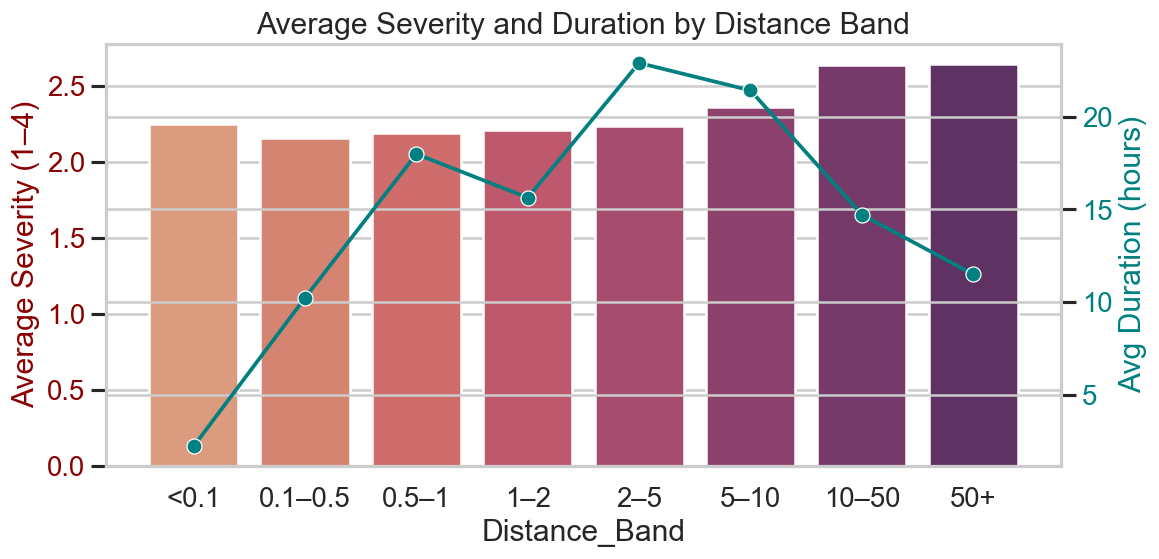

Short urban events (<0.1 mi) dominate volume but remain low severity, while long highway closures (>5 mi) show much higher severity and clearance time — classic signatures of major interstates and multi-vehicle incidents.
Temporal analysis complete — workload patterns and operational bottlenecks identified.


In [8]:
# =====================================================
# TEMPORAL PATTERNS — RESOURCE ALLOCATION FOCUS
# =====================================================
# This section examines WHEN accidents occur and how timing affects
# both frequency and operational workload.
# 
# Key questions explored:
#   • What hours and days see the most incidents?
#   • Do incident durations follow the same pattern as volume?
#   • How do temporal and distance dynamics influence severity?
#
# These insights guide DOT decisions on shift scheduling,
# real-time monitoring, and proactive traffic management.

print_heading("Temporal Patterns (Operational Workload)")

# Copy working DataFrame to avoid mutating global data
temp_df = accidents_df.copy()

# -----------------------------------------------------
# 1. Accidents by Hour of Day
# -----------------------------------------------------
print_sub_heading("Accidents by Hour of Day")

# Group and summarize accident count and total duration per hour
hourly = (
    temp_df.groupby('Hour')
    .agg(Accidents=('ID', 'count'), Total_Duration=('Duration_hours', 'sum'))
    .reset_index()
)

# Plot: Hourly accident frequency
plt.figure(figsize=(10,5))
sns.barplot(data=hourly, x='Hour', y='Accidents', palette='crest')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Accident Count (millions)")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.show()

print(
    "Accidents follow a strong diurnal rhythm — peaking during commute hours (7–9 AM and 4–6 PM). "
    "These peaks correspond to maximum roadway exposure and congestion."
)

# -----------------------------------------------------
# 1b. Aggregate Duration by Hour
# -----------------------------------------------------
print_sub_heading("Aggregate Incident Duration by Hour of Day")

# Aggregate total duration by hour to reveal clearance workload
hourly_duration = accidents_df.groupby("Hour")["Duration_hours"].sum()

plt.figure(figsize=(10,5))
plt.plot(hourly_duration.index, hourly_duration.values / 1e6, marker='o', color='red')
plt.title("Aggregate Incident Duration by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Incident Duration (millions of hours)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(
    "While incident *count* peaks during rush hours, total *duration* remains high well into the evening — "
    "indicating prolonged congestion and slower clear times after dark."
)

# -----------------------------------------------------
# 2. Accidents by Day of Week
# -----------------------------------------------------
print_sub_heading("Accidents by Day of Week")

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_day = (
    temp_df.groupby('DayOfWeek')
    .agg(Accidents=('ID', 'count'), Avg_Duration=('Duration_hours', 'mean'))
    .reindex(day_order)
    .reset_index()
)

# Dual-axis visualization — frequency + average duration
fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(data=by_day, x='DayOfWeek', y='Accidents', palette='crest', ax=ax1)
ax1.set_ylabel("Accident Count (millions)")
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
ax1.set_xlabel("Day of Week")
ax1.set_title("Accidents and Average Duration by Day of Week")

ax2 = ax1.twinx()
sns.lineplot(data=by_day, x='DayOfWeek', y='Avg_Duration', color='red', marker='o', ax=ax2)
ax2.set_ylabel("Avg Duration (hours)", color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

print(
    "Weekdays dominate crash volume, while weekends show fewer incidents but slightly longer durations — "
    "suggesting slower clearances and thinner emergency staffing."
)

# -----------------------------------------------------
# 3. Monthly and Yearly Trends
# -----------------------------------------------------
print_sub_heading("Accidents Over Time (Monthly and Yearly Trends)")

# Aggregate by month/year for long-term pattern detection
monthly = (
    temp_df.groupby(['Year','Month'])
    .size()
    .reset_index(name='Accidents')
)
monthly['Date'] = pd.to_datetime(monthly['Year'].astype(str) + '-' + monthly['Month'].astype(str) + '-01')

# Line plot of temporal trend
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x='Date', y='Accidents', marker='o', color='teal')
plt.title("Monthly Accident Trend (2016–2023)")
plt.xlabel("Date")
plt.ylabel("Accident Count (millions)")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.show()

print(
    "Accident volumes rise steadily through 2019, drop sharply during 2020 lockdowns, and recover post-pandemic. "
    "Note: early years (2016–2017) likely underrepresent true counts due to incomplete reporting coverage."
)

# -----------------------------------------------------
# 4. Heatmap: Hour × Day Workload
# -----------------------------------------------------
print_sub_heading("Workload Heatmap: Hour vs Day of Week")

# Pivot accident frequency into a weekly-hourly grid
pivot = (
    temp_df.groupby(['DayOfWeek', 'Hour'])
    .agg(Accidents=('ID', 'count'))
    .unstack(fill_value=0)
    .reindex(day_order)
    / 1e3  # scaled in thousands
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Accident Count (thousands)'})
plt.title("Accidents by Hour and Day of Week (in Thousands)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.xticks(ticks=np.arange(0.5, 24.5), labels=[str(h) for h in range(24)], rotation=0)
plt.show()

print(
    "The heatmap reveals distinct weekday commuter peaks — especially around 8 AM and 5 PM. "
    "Sundays remain consistently low across all hours."
)

# -----------------------------------------------------
# 5. Average Duration by Hour
# -----------------------------------------------------
print_sub_heading("Average Duration by Hour (Workload Proxy)")

# Mean clearance duration per hour of day
duration_by_hour = temp_df.groupby('Hour')['Duration_hours'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=duration_by_hour.index, y=duration_by_hour.values, palette="crest")
plt.title("Average Accident Duration by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration (hours)")
plt.show()

print(
    "Average durations increase slightly at night — likely reflecting reduced responder availability and visibility challenges."
)

# -----------------------------------------------------
# 6. Average Severity by Hour
# -----------------------------------------------------
print_sub_heading("Average Severity by Hour")

# Compute average severity for each hour
severity_by_hour = temp_df.groupby('Hour')['Severity'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=severity_by_hour.index, y=severity_by_hour.values, palette="flare")
plt.title("Average Accident Severity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Severity (1–4)")
plt.show()

print(
    "Severity remains relatively stable throughout the day (≈2.0–2.3), "
    "suggesting time of day affects frequency and duration more than impact intensity."
)

# -----------------------------------------------------
# 7. Distance Distribution by Severity
# -----------------------------------------------------
print_sub_heading("Accident Distance Distribution (Log Scale by Severity)")

print(
    "Distance (mi) measures roadway extent of an accident — shorter spans reflect localized events, "
    "while longer spans often indicate major highway closures or pileups."
)
print(
    "Violin plots below display distribution shape by severity level:\n"
    "• Width = how common a given distance is.\n"
    "• Lines = quartiles (median, 25th, 75th percentiles).\n"
    "• Y-axis is logarithmic (0.1 → 1 → 10 miles)."
)

# Filter and plot
distance_df = accidents_df[(accidents_df["Distance(mi)"] > 0) & (accidents_df["Distance(mi)"] <= 50)]

plt.figure(figsize=(10,6))
sns.violinplot(
    data=distance_df,
    x="Severity", y="Distance(mi)",
    palette="crest", inner="quartile", scale="width"
)
plt.yscale("log")
plt.title("Accident Distance Distribution by Severity (Log Scale)")
plt.xlabel("Severity Level (1–4)")
plt.ylabel("Distance (miles, log scale)")
plt.show()

# -----------------------------------------------------
# 8. Severity and Duration by Distance Band
# -----------------------------------------------------
print_sub_heading("Severity and Duration by Distance Band")

print(
    "Grouping distances into discrete bands shows how roadway context changes both severity and response time."
)

# Define distance bins and labels
bins = [0, 0.1, 0.5, 1, 2, 5, 10, 50, np.inf]
labels = ["<0.1", "0.1–0.5", "0.5–1", "1–2", "2–5", "5–10", "10–50", "50+"]

dist_df = accidents_df.copy()
dist_df["Distance_Band"] = pd.cut(dist_df["Distance(mi)"], bins=bins, labels=labels, include_lowest=True)

band_summary = (
    dist_df.groupby("Distance_Band")[["Severity", "Duration_hours"]]
    .mean()
    .reset_index()
)

# Dual-axis plot
fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(data=band_summary, x="Distance_Band", y="Severity", palette="flare", ax=ax1)
ax1.set_ylabel("Average Severity (1–4)", color="darkred")
ax1.tick_params(axis="y", labelcolor="darkred")

ax2 = ax1.twinx()
sns.lineplot(data=band_summary, x="Distance_Band", y="Duration_hours", color="teal", marker="o", ax=ax2)
ax2.set_ylabel("Avg Duration (hours)", color="teal")
ax2.tick_params(axis="y", labelcolor="teal")

plt.title("Average Severity and Duration by Distance Band")
plt.xlabel("Distance Band (miles)")
plt.tight_layout()
plt.show()

print(
    "Short urban events (<0.1 mi) dominate volume but remain low severity, "
    "while long highway closures (>5 mi) show much higher severity and clearance time — "
    "classic signatures of major interstates and multi-vehicle incidents."
)

print("Temporal analysis complete — workload patterns and operational bottlenecks identified.")

### Temporal Takeaways

#### **1. Daily and weekly rhythm**
Accidents follow a pronounced **diurnal cycle**, peaking sharply between **7–9 AM** and **4–6 PM**, matching rush-hour traffic flows.
Counts taper overnight but never fully drop to zero, showing a persistent baseline of low-traffic incidents (e.g., fatigue or impaired driving).
Weekdays dominate total volume, while **Saturday and Sunday** see fewer but slightly longer-duration crashes — consistent with leisure travel and reduced emergency response staffing.

#### **2. Duration and workload timing**
Aggregate incident duration (total hours of disruption) also peaks during **morning and evening commutes**, confirming that congestion amplifies both accident likelihood and clearance time.
Durations rise again slightly after **8 PM**, when reduced visibility and responder availability slow recovery.

#### **3. Coverage caveat (pre-2021)**
Early years reflect dataset build-out, not true national volume. The apparent rise through 2019 is largely coverage expansion. The 2020 dip is real (lockdowns) but its magnitude is unreliable given incomplete coverage. Use 2021–2023 for trustworthy trend comparisons.

Comparisons across years should either (a) restrict to 2021+, or (b) include year/coverage controls (year fixed effects, site/reporting-source dummies) to avoid conflating coverage ramp with real signal.

#### **4. Severity and duration patterns**
Average **severity remains relatively stable** throughout the day, suggesting consistent reporting and classification standards.
However, average **accident duration increases modestly at night**, likely due to lower visibility and resource constraints.

#### **5. Distance and severity correlations**
Distance distributions (log-scaled) reveal:
* **Short, localized events** (<0.5 mi) dominate lower severity (1–2).
* **Longer spans** (>10 mi) correspond to higher severity (3–4), reflecting highway-scale closures and multi-vehicle events.

⠀Grouping by distance band shows a clear **severity-duration relationship** — longer incidents are both more severe and slower to resolve.

#### **Summary insight**
Temporal analysis confirms a dual commuter-peak pattern, strong weekday dominance, and nighttime operational slowdowns. Multi-year data illustrates how macro disruptions (like COVID) affect overall volume but not underlying daily rhythm. The relationship between distance, severity, and duration provides a direct window into **bottleneck risk and response inefficiency**, anchoring future predictive modeling around both time and scale dimensions.


---

### Geographic Analysis


Geographic Analysis (Operational Focus)


----------------------------------------
Accidents per 1,000 Residents
----------------------------------------

To normalize for population differences, accident counts are divided by each state’s 2020 Census population. This highlights relative risk rather than sheer volume.


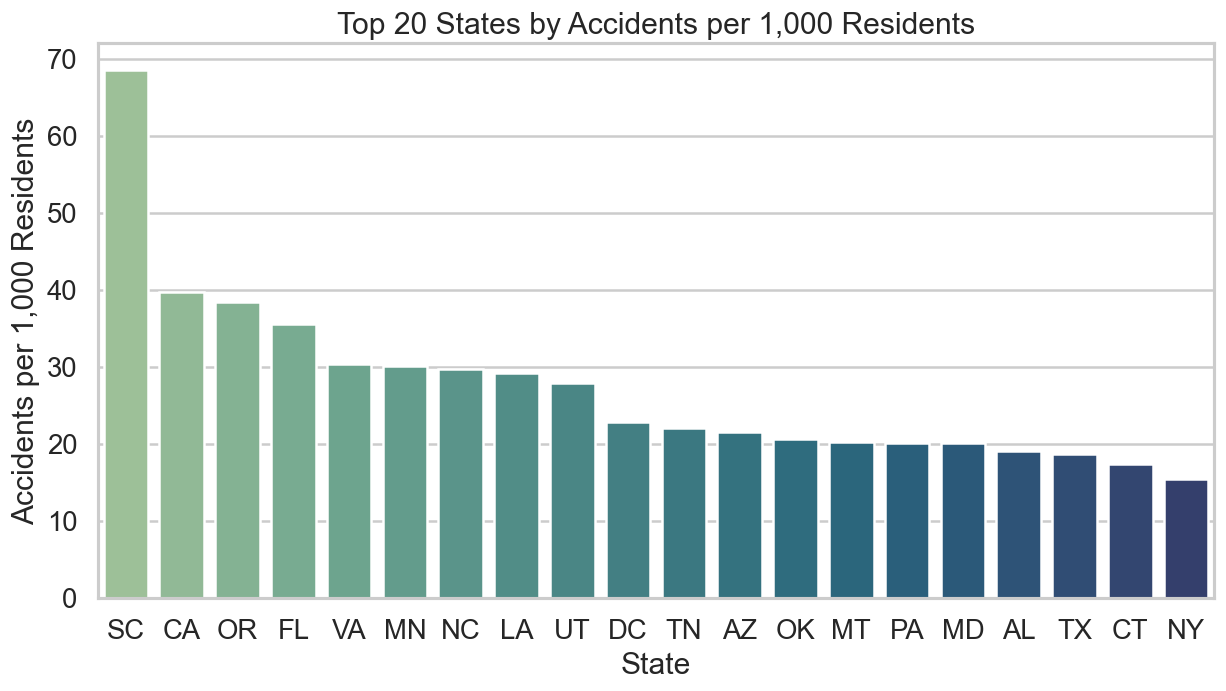

Smaller states with dense traffic networks (e.g., DC, DE, RI) often top the per-capita list, showing that urban density and travel exposure drive disproportionate risk.

----------------------------------------
Average Severity by State (States with >1,000 Records)
----------------------------------------



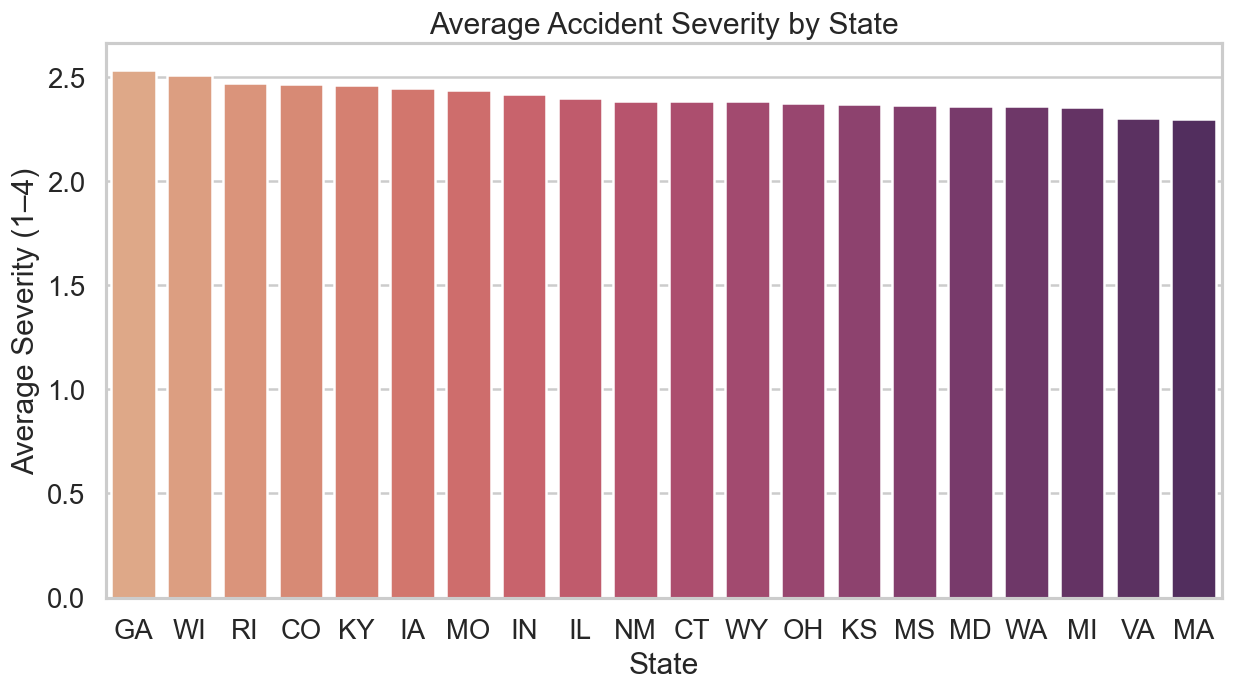

Southern and western states often show higher average severity, reflecting longer rural response distances and higher-speed highway environments.

----------------------------------------
Localized Hotspots by City and County
----------------------------------------

While state summaries capture regional trends, local hotspots pinpoint operational pressure points — urban bottlenecks or major interstates that drive recurring incidents.


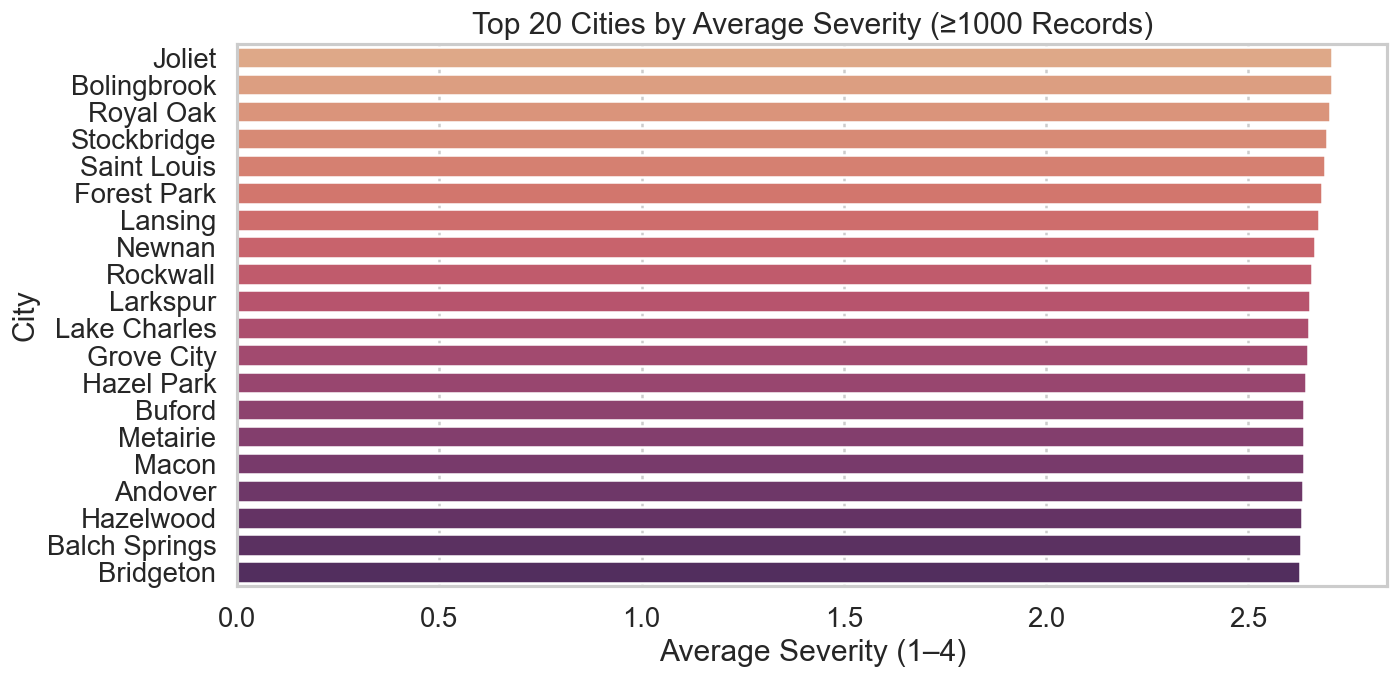

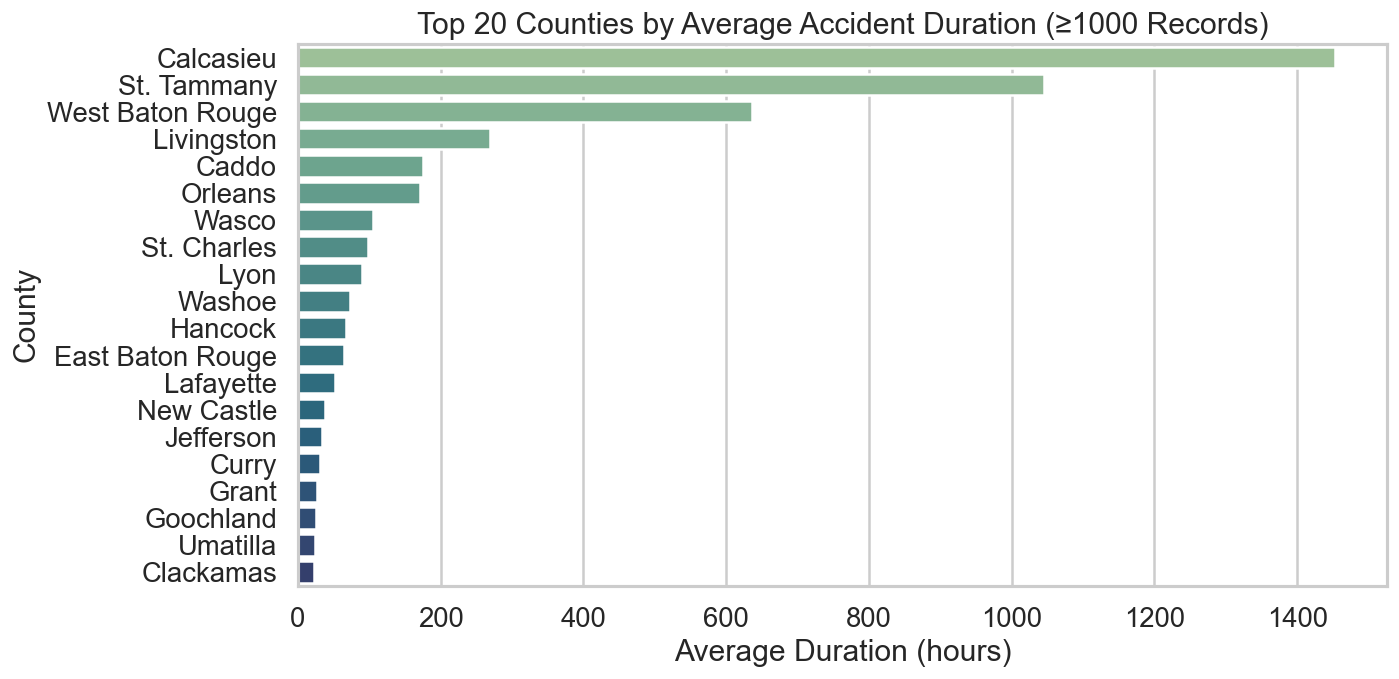

County-level duration hotspots often align with rural areas — fewer responders and longer clear times, suggesting opportunities for targeted resource deployment.

----------------------------------------
Average Accident Duration by State (≤24 Hours)
----------------------------------------



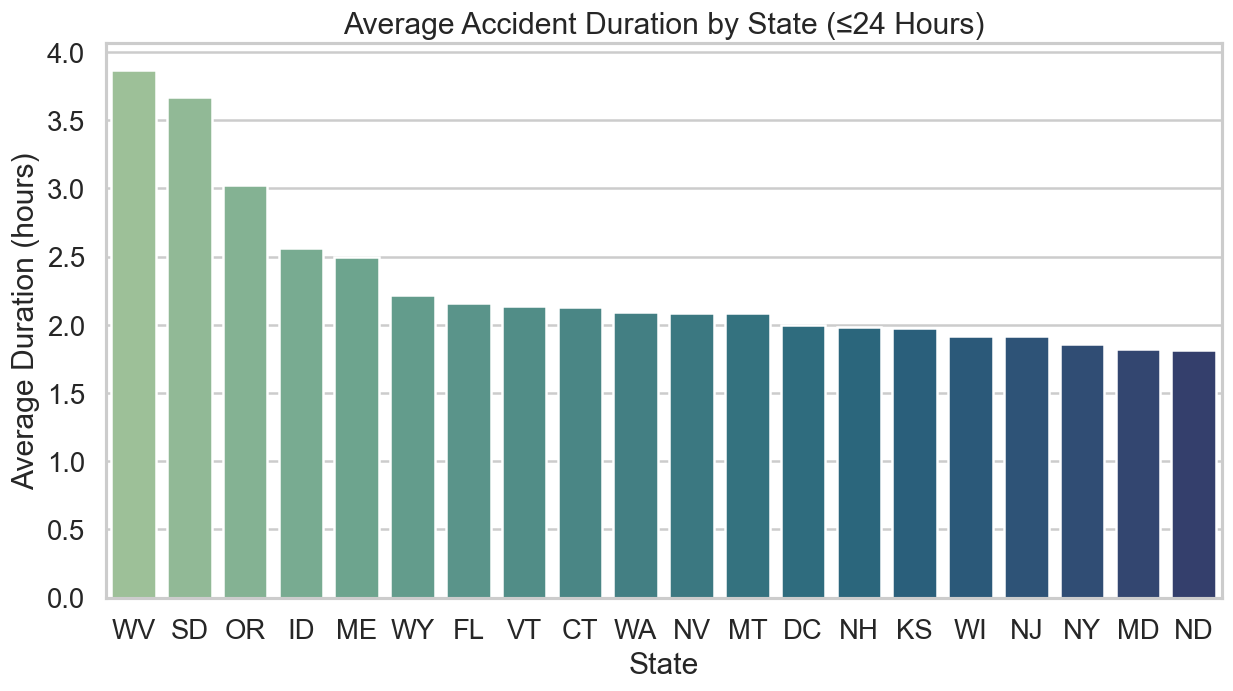

High-duration states often coincide with lower population density — reinforcing that rurality extends both incident clearance time and severity.

----------------------------------------
Urban vs Suburban vs Rural Analysis
----------------------------------------

By merging RUCA classifications, we can evaluate how accident dynamics differ by area type. Urban areas dominate volume, while rural areas carry higher severity and longer durations per incident.


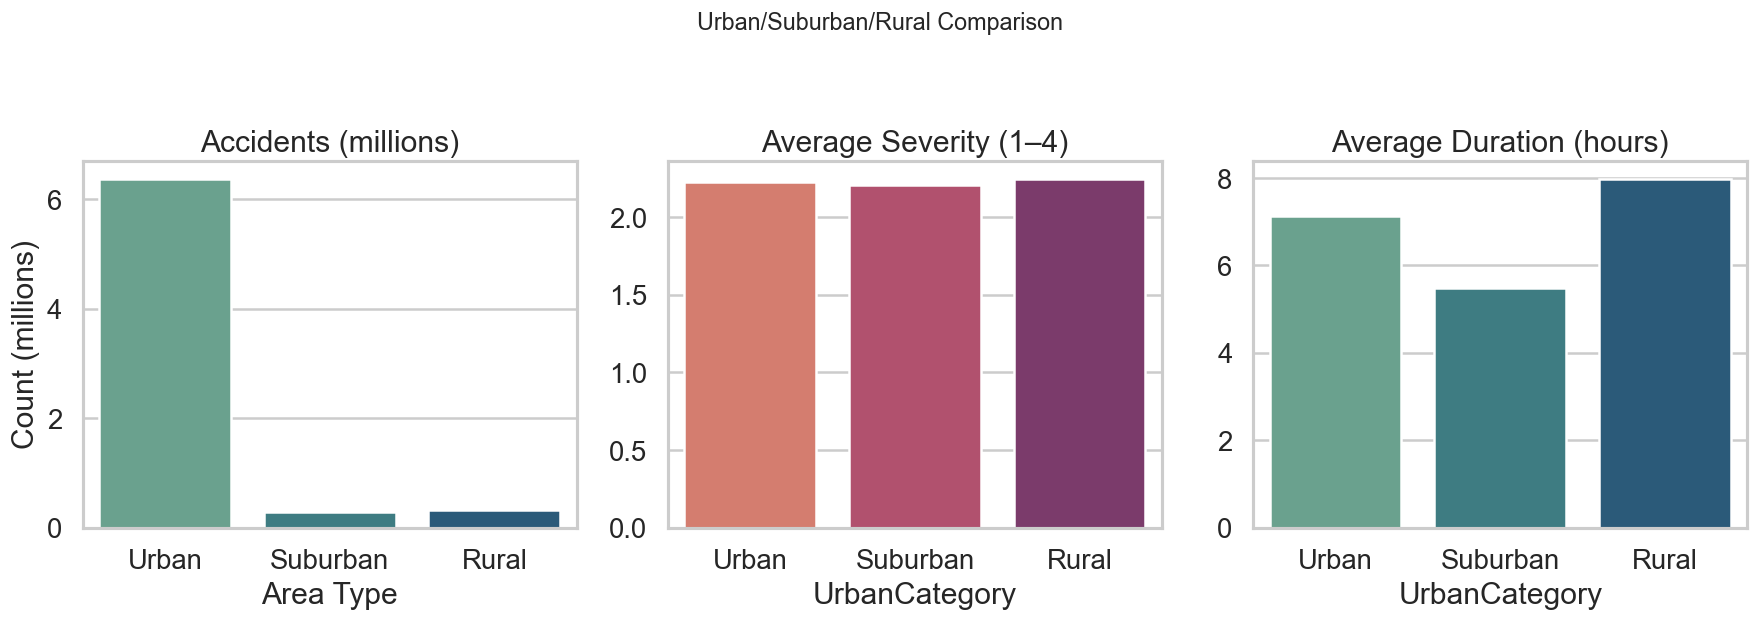

Urban areas: High volume, low severity, fast clearance.
Suburban areas: Balanced profile.
Rural areas: Low volume but significantly higher severity and duration — underscoring the rural response gap.

----------------------------------------
Choropleth Map: Accident Density by State
----------------------------------------



The map reinforces regional concentration patterns — especially along the Eastern Seaboard, Great Lakes, and Southern corridors.

----------------------------------------
Severity vs Frequency by State
----------------------------------------



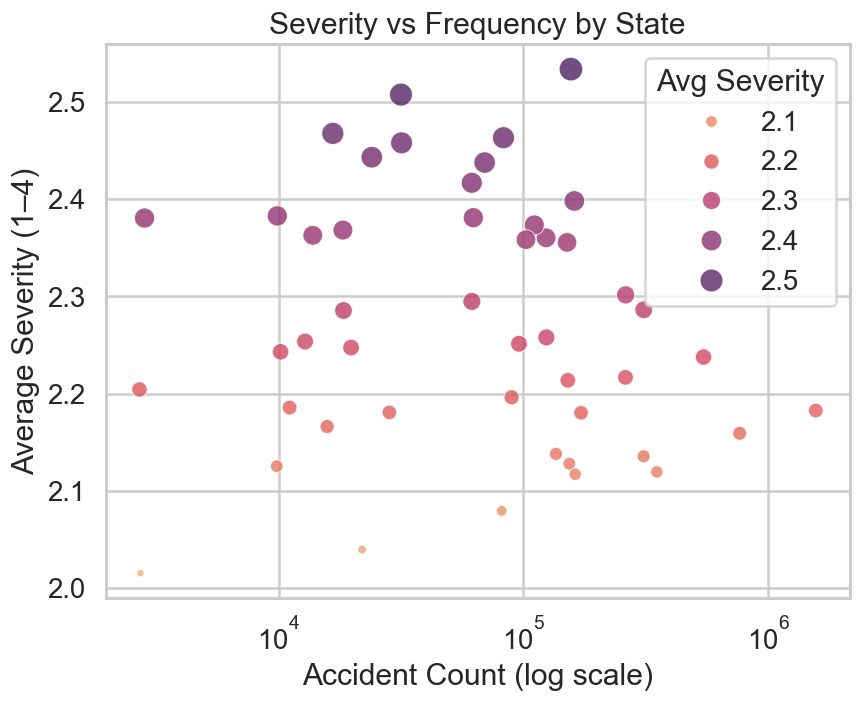

States with both high accident counts and elevated severity — notably southern and mountain regions — represent prime targets for focused mitigation programs.
Geographic analysis complete — spatial risk and rural response disparities identified.


In [9]:
# =====================================================
# GEOGRAPHIC INSIGHTS — OPERATIONAL FOCUS
# =====================================================
# This section examines WHERE accidents occur and how geography influences
# frequency, severity, and duration. By connecting spatial patterns to
# population exposure and area type (urban vs. rural), DOT can prioritize
# infrastructure investment and response resource allocation.

print_heading("Geographic Analysis (Operational Focus)")

geo_df = accidents_df.copy()

# -----------------------------------------------------
# 1. Accidents per 1,000 Residents (Top 20 States)
# -----------------------------------------------------
print_sub_heading("Accidents per 1,000 Residents")

print(
    "To normalize for population differences, accident counts are divided by each state’s 2020 Census population. "
    "This highlights relative risk rather than sheer volume."
)

# Compute per-capita accident rates
state_counts = geo_df['State'].value_counts()
state_rate = (state_counts / pd.Series(state_population)) * 1000
state_rate = state_rate.dropna().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_rate.index, y=state_rate.values, palette="crest")
plt.title("Top 20 States by Accidents per 1,000 Residents")
plt.xlabel("State")
plt.ylabel("Accidents per 1,000 Residents")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

print(
    "Smaller states with dense traffic networks (e.g., DC, DE, RI) often top the per-capita list, "
    "showing that urban density and travel exposure drive disproportionate risk."
)

# -----------------------------------------------------
# 2. Average Severity by State (Threshold: >1,000 Records)
# -----------------------------------------------------
print_sub_heading("Average Severity by State (States with >1,000 Records)")

valid_states = geo_df['State'].value_counts()
valid_states = valid_states[valid_states > 1000].index
filtered = geo_df[geo_df['State'].isin(valid_states)]

state_severity = filtered.groupby('State')['Severity'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=state_severity.index, y=state_severity.values, palette="flare")
plt.title("Average Accident Severity by State")
plt.xlabel("State")
plt.ylabel("Average Severity (1–4)")
plt.show()

print(
    "Southern and western states often show higher average severity, reflecting longer rural response distances "
    "and higher-speed highway environments."
)

# -----------------------------------------------------
# 3. Localized Hotspots — City and County Focus
# -----------------------------------------------------
print_sub_heading("Localized Hotspots by City and County")

print(
    "While state summaries capture regional trends, local hotspots pinpoint operational pressure points — "
    "urban bottlenecks or major interstates that drive recurring incidents."
)

# Top 20 cities by severity (≥1000 records)
city_stats = (
    accidents_df.groupby("City")
    .filter(lambda x: len(x) >= 1000)
    .groupby("City")["Severity"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=city_stats.values, y=city_stats.index, palette="flare")
plt.title("Top 20 Cities by Average Severity (≥1000 Records)")
plt.xlabel("Average Severity (1–4)")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# Top 20 counties by duration (≥1000 records)
county_stats = (
    accidents_df.groupby("County")
    .filter(lambda x: len(x) >= 1000)
    .groupby("County")["Duration_hours"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=county_stats.values, y=county_stats.index, palette="crest")
plt.title("Top 20 Counties by Average Accident Duration (≥1000 Records)")
plt.xlabel("Average Duration (hours)")
plt.ylabel("County")
plt.tight_layout()
plt.show()

print(
    "County-level duration hotspots often align with rural areas — fewer responders and longer clear times, "
    "suggesting opportunities for targeted resource deployment."
)

# -----------------------------------------------------
# 4. Average Duration by State (≤24 Hours Filter)
# -----------------------------------------------------
print_sub_heading("Average Accident Duration by State (≤24 Hours)")

filtered_duration = geo_df[geo_df['Duration_hours'] <= 24]
duration_by_state = (
    filtered_duration.groupby('State')['Duration_hours']
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=duration_by_state.index, y=duration_by_state.values, palette="crest")
plt.title("Average Accident Duration by State (≤24 Hours)")
plt.xlabel("State")
plt.ylabel("Average Duration (hours)")
plt.show()

print(
    "High-duration states often coincide with lower population density — reinforcing that rurality extends both "
    "incident clearance time and severity."
)

# -----------------------------------------------------
# 5. Urban vs Suburban vs Rural — Volume, Severity, Duration
# -----------------------------------------------------
print_sub_heading("Urban vs Suburban vs Rural Analysis")

print(
    "By merging RUCA classifications, we can evaluate how accident dynamics differ by area type. "
    "Urban areas dominate volume, while rural areas carry higher severity and longer durations per incident."
)

ruca_df_check = geo_df.dropna(subset=['UrbanCategory'])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Urban/Suburban/Rural Comparison", fontsize=14, y=1.05)

# Accident Count
area_counts = ruca_df_check['UrbanCategory'].value_counts().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=area_counts.index, y=area_counts.values/1e6, ax=axes[0], palette="crest")
axes[0].set_title("Accidents (millions)")
axes[0].set_ylabel("Count (millions)")
axes[0].set_xlabel("Area Type")

# Severity
severity_by_area = ruca_df_check.groupby('UrbanCategory')['Severity'].mean().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=severity_by_area.index, y=severity_by_area.values, ax=axes[1], palette="flare")
axes[1].set_title("Average Severity (1–4)")
axes[1].set_ylabel("")

# Duration
duration_by_area = ruca_df_check.groupby('UrbanCategory')['Duration_hours'].mean().reindex(['Urban','Suburban','Rural'])
sns.barplot(x=duration_by_area.index, y=duration_by_area.values, ax=axes[2], palette="crest")
axes[2].set_title("Average Duration (hours)")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

print(
    "Urban areas: High volume, low severity, fast clearance.\n"
    "Suburban areas: Balanced profile.\n"
    "Rural areas: Low volume but significantly higher severity and duration — underscoring the rural response gap."
)

# -----------------------------------------------------
# 6. Choropleth Map — State-Level Accident Density
# -----------------------------------------------------
print_sub_heading("Choropleth Map: Accident Density by State")

state_counts_map = geo_df['State'].value_counts().reset_index()
state_counts_map.columns = ['State', 'Accident_Count']

fig = px.choropleth(
    state_counts_map,
    locations="State",
    locationmode="USA-states",
    color="Accident_Count",
    color_continuous_scale="YlOrRd",
    scope="usa",
    title="U.S. Accidents by State (Choropleth View)",
)
fig.update_layout(width=900, height=500)
fig.show()

print(
    "The map reinforces regional concentration patterns — especially along the Eastern Seaboard, Great Lakes, and Southern corridors."
)

# -----------------------------------------------------
# 7. Severity vs Frequency — State-Level Scatter
# -----------------------------------------------------
print_sub_heading("Severity vs Frequency by State")

state_stats = (
    filtered.groupby('State')
    .agg({'Severity': 'mean', 'ID': 'count'})
    .rename(columns={'ID': 'Accident_Count'})
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=state_stats,
    x='Accident_Count',
    y='Severity',
    hue='Severity',
    size='Severity',
    sizes=(20,200),
    palette="flare",
    alpha=0.8
)
plt.title("Severity vs Frequency by State")
plt.xlabel("Accident Count (log scale)")
plt.ylabel("Average Severity (1–4)")
plt.xscale('log')
plt.legend(title="Avg Severity")
plt.show()

print(
    "States with both high accident counts and elevated severity — notably southern and mountain regions — "
    "represent prime targets for focused mitigation programs."
)

print("Geographic analysis complete — spatial risk and rural response disparities identified.")

### Geographic Takeaways

#### **1. National and state-level overview**
* **California, Texas, and Florida** dominate total crash volumes, consistent with population and vehicle density.
* When normalized by population, **Southern and Southeastern states (e.g., GA, SC, LA, NC)** lead in accidents per 1,000 residents — highlighting regional exposure rather than sheer size.
* Smaller, high-density states (e.g., DC, RI) also rank high per capita, showing how **urban congestion** drives frequency even in compact geographies.
* The choropleth confirms a clear east–south concentration: **Eastern Seaboard, Great Lakes, and Gulf states** are national hot zones.

#### **2. Duration and severity patterns by region**
* **High-duration states** (WV, SD, OR, ID) often coincide with **low population density**, reinforcing that **rural infrastructure extends clearance times**.
* **Severity** varies less across states but trends higher in **southern and mountain regions**, where long response distances and mixed road types increase risk.
* State-level scatterplots reveal **no strict correlation** between frequency and severity — large-volume states experience many low-severity incidents, while smaller, rural states see fewer but more intense events.

#### **3. County-level and city hotspots**
* Long-duration counties (e.g., Calcasieu LA, St. Tammany LA, and Pulaski AR) align with **rural or semi-rural profiles**, pointing to responder scarcity.
* Top-severity urban centers include **Atlanta, Charlotte, and Baton Rouge**, where dense traffic and complex interchanges elevate risk.

#### **4. Urban vs. suburban vs. rural contrasts**
* **Urban zones:** Highest crash volume, lowest severity, shortest duration — strong coverage and rapid response.
* **Suburban zones:** Moderate frequency, balanced severity — transition zones for commuter accidents.
* **Rural zones:** Lowest frequency but **highest average severity and duration**, confirming a persistent **urban–rural response gap**.

#### **Summary insight**
Geographic segmentation clarifies that **volume and risk are decoupled**: urban areas drive exposure, while rural ones drive severity and clearance time. Population-normalized metrics reveal that **southern and mid-Atlantic states** face disproportionate crash risk relative to population, underscoring where resource allocation, road design, and emergency response investments could most reduce harm.

### 

---

### Environmental Analysis


Environmental Factors (Operational Risk & Resource Demand)


----------------------------------------
Accident Summary by Weather Condition
----------------------------------------

Response Burden quantifies how much total strain each weather condition places on DOT operations — balancing frequency, severity, and duration into a single normalized index (0–100).

----------------------------------------
Top Weather Conditions by Response Burden
----------------------------------------



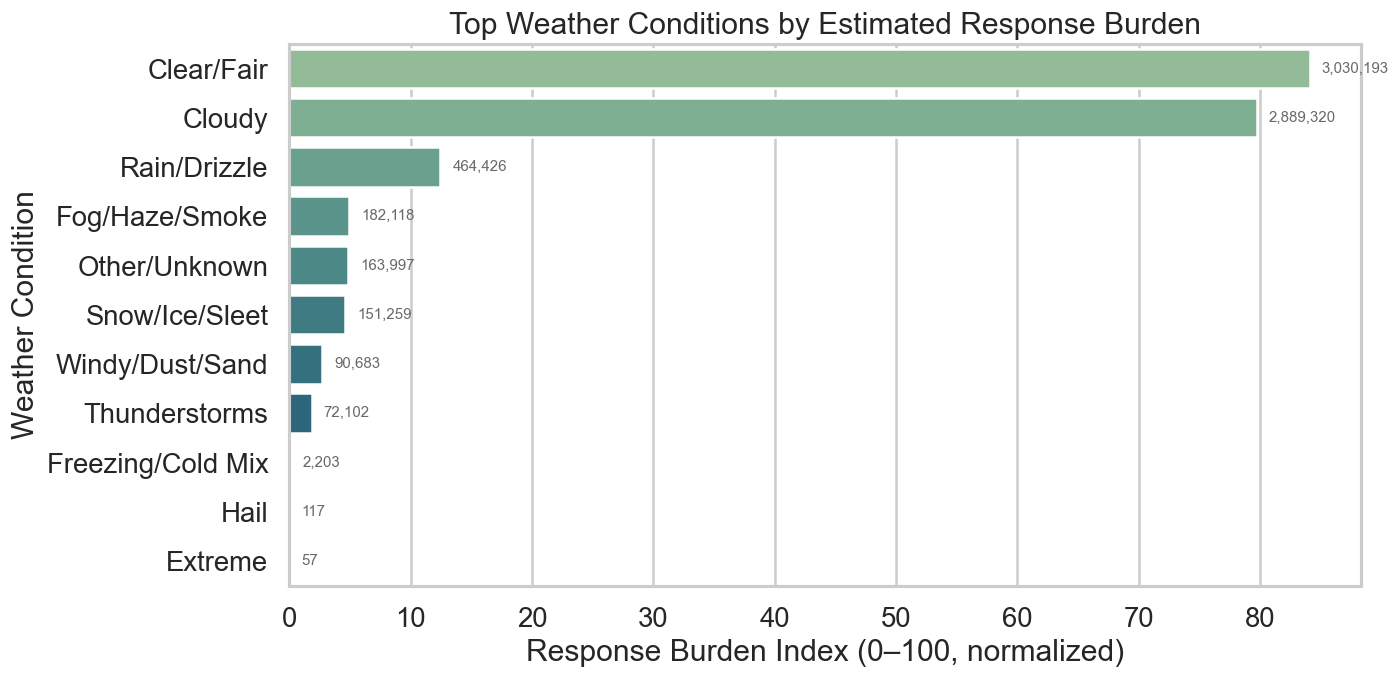

Rain, fog, and snow dominate total response demand due to their combination of high frequency and extended clearance times. Even light rain carries heavy operational weight when multiplied by exposure volume.

----------------------------------------
Per-Incident Response Burden (Normalized Severity × Duration)
----------------------------------------



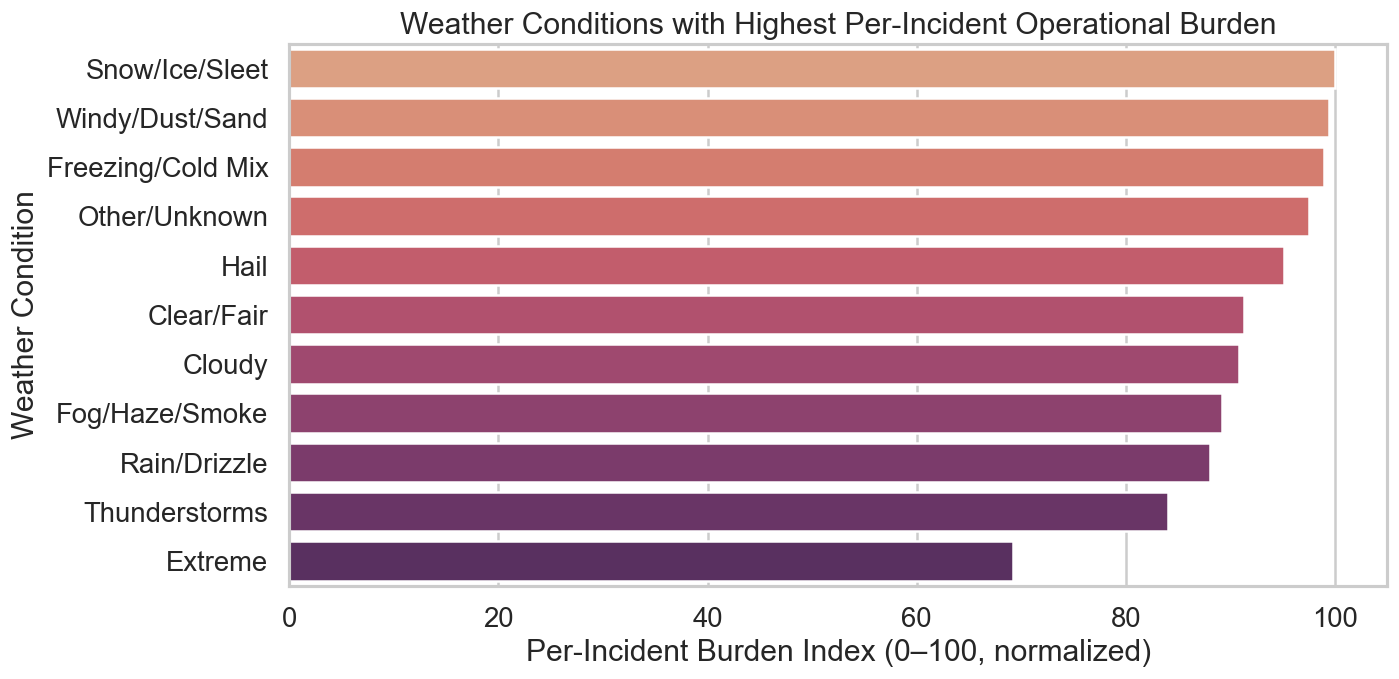

Freezing rain, heavy snow, and fog rank highest per incident — each crash under these conditions demands more time and coordination to resolve.

----------------------------------------
Operational Risk Matrix: Frequency × Severity × Duration
----------------------------------------



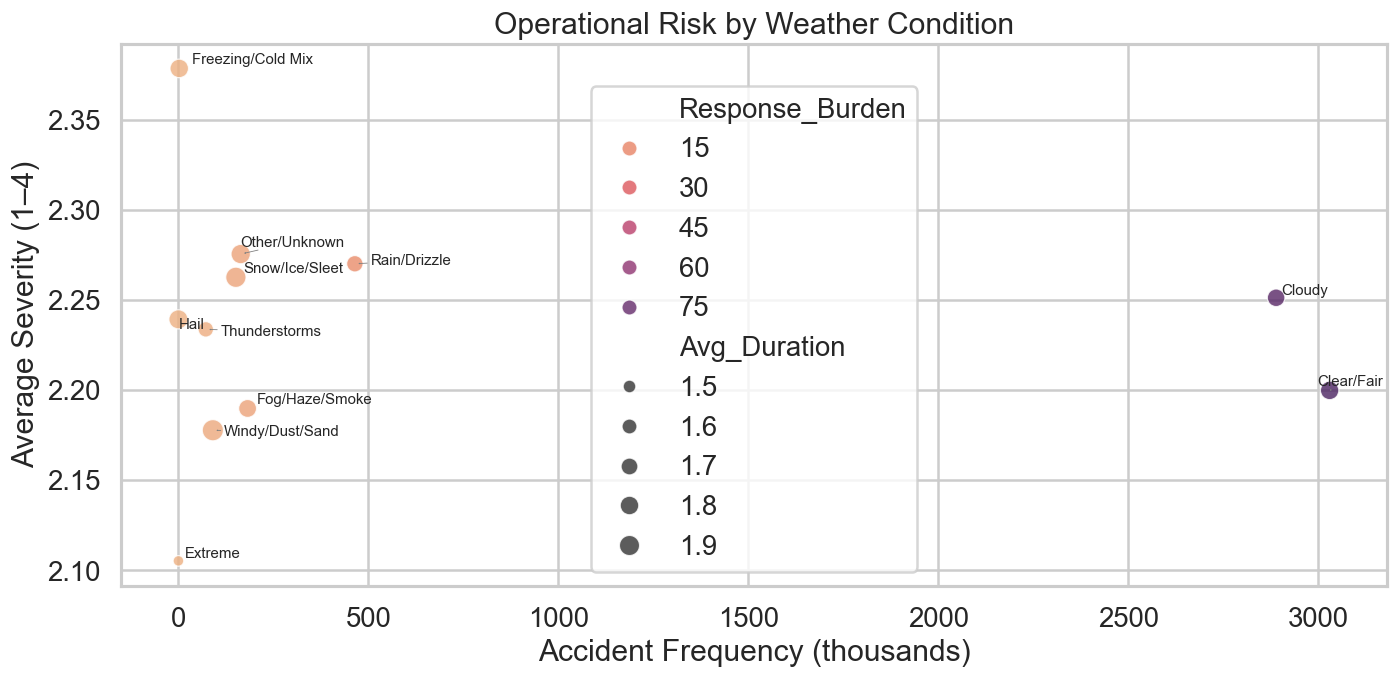

Fog and snow cluster in the high-severity, long-duration quadrant — ideal candidates for proactive warning systems and surge resource planning.

----------------------------------------
Accident Frequency vs Average Duration by Weather Condition
----------------------------------------



/var/folders/ch/63xjc1fn56v6flb88p6278j80000gn/T/ipykernel_55000/2626735793.py:170: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



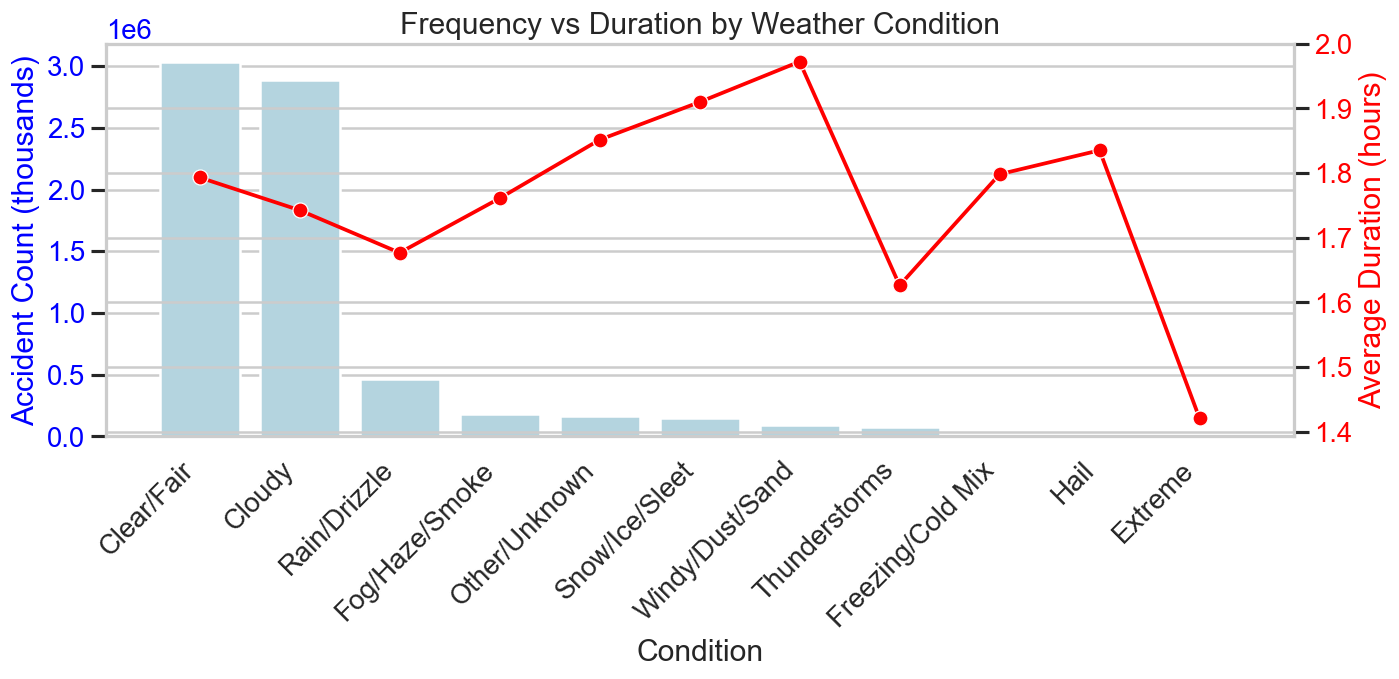

Light precipitation dominates frequency, but duration spikes sharply for snow and fog — conditions where reduced visibility delays clearance and increases secondary crashes.

----------------------------------------
Twilight and Light Conditions
----------------------------------------



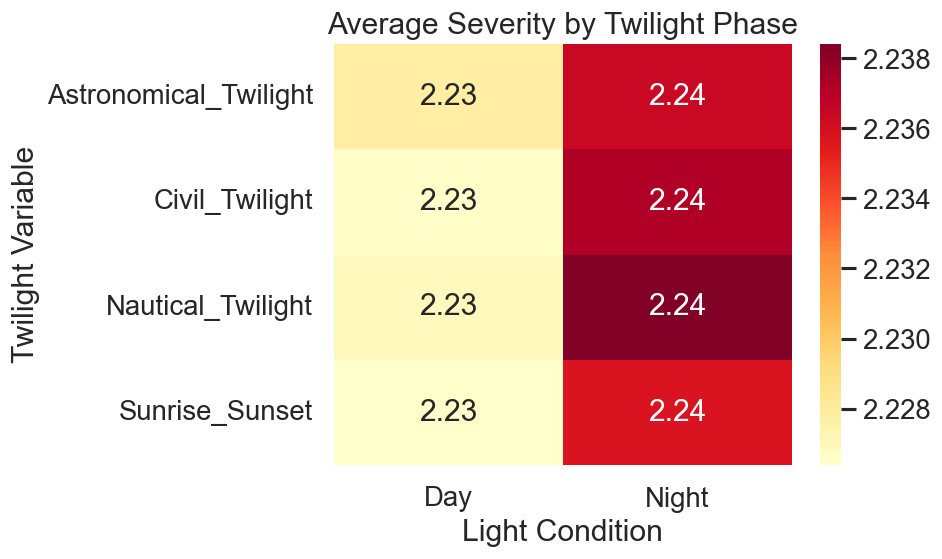

Severity increases slightly during nautical and astronomical twilight — periods when ambient light is lowest but drivers have not fully adapted to darkness.

----------------------------------------
Combined Risk: Day/Night × Weather Condition
----------------------------------------



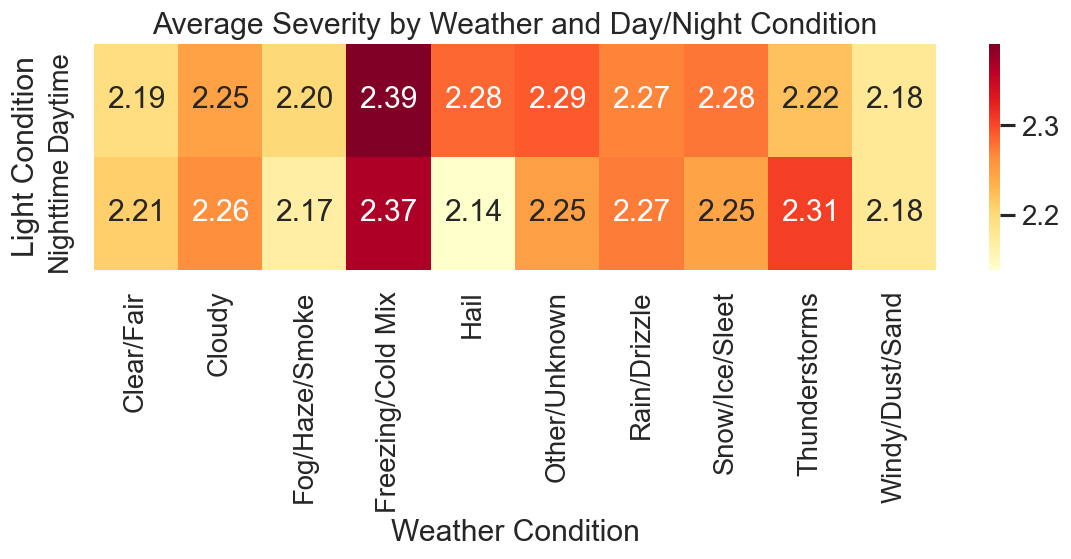

Nighttime conditions amplify risk across nearly all weather types — especially fog and rain — suggesting strong value in adaptive lighting and nighttime speed enforcement.

----------------------------------------
Wind Speed and Direction Influence on Severity
----------------------------------------



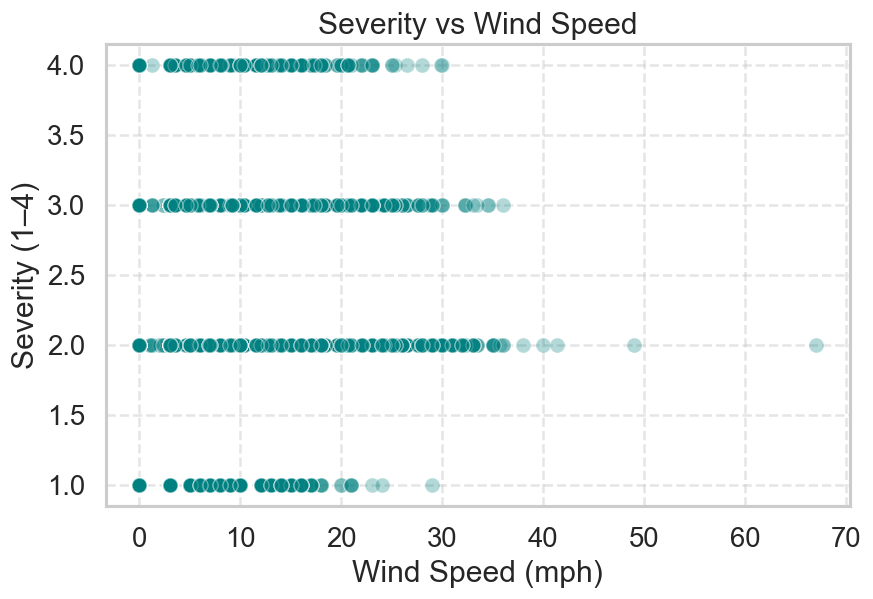


----------------------------------------
Correlation Heatmap: Environmental & Outcome Variables
----------------------------------------



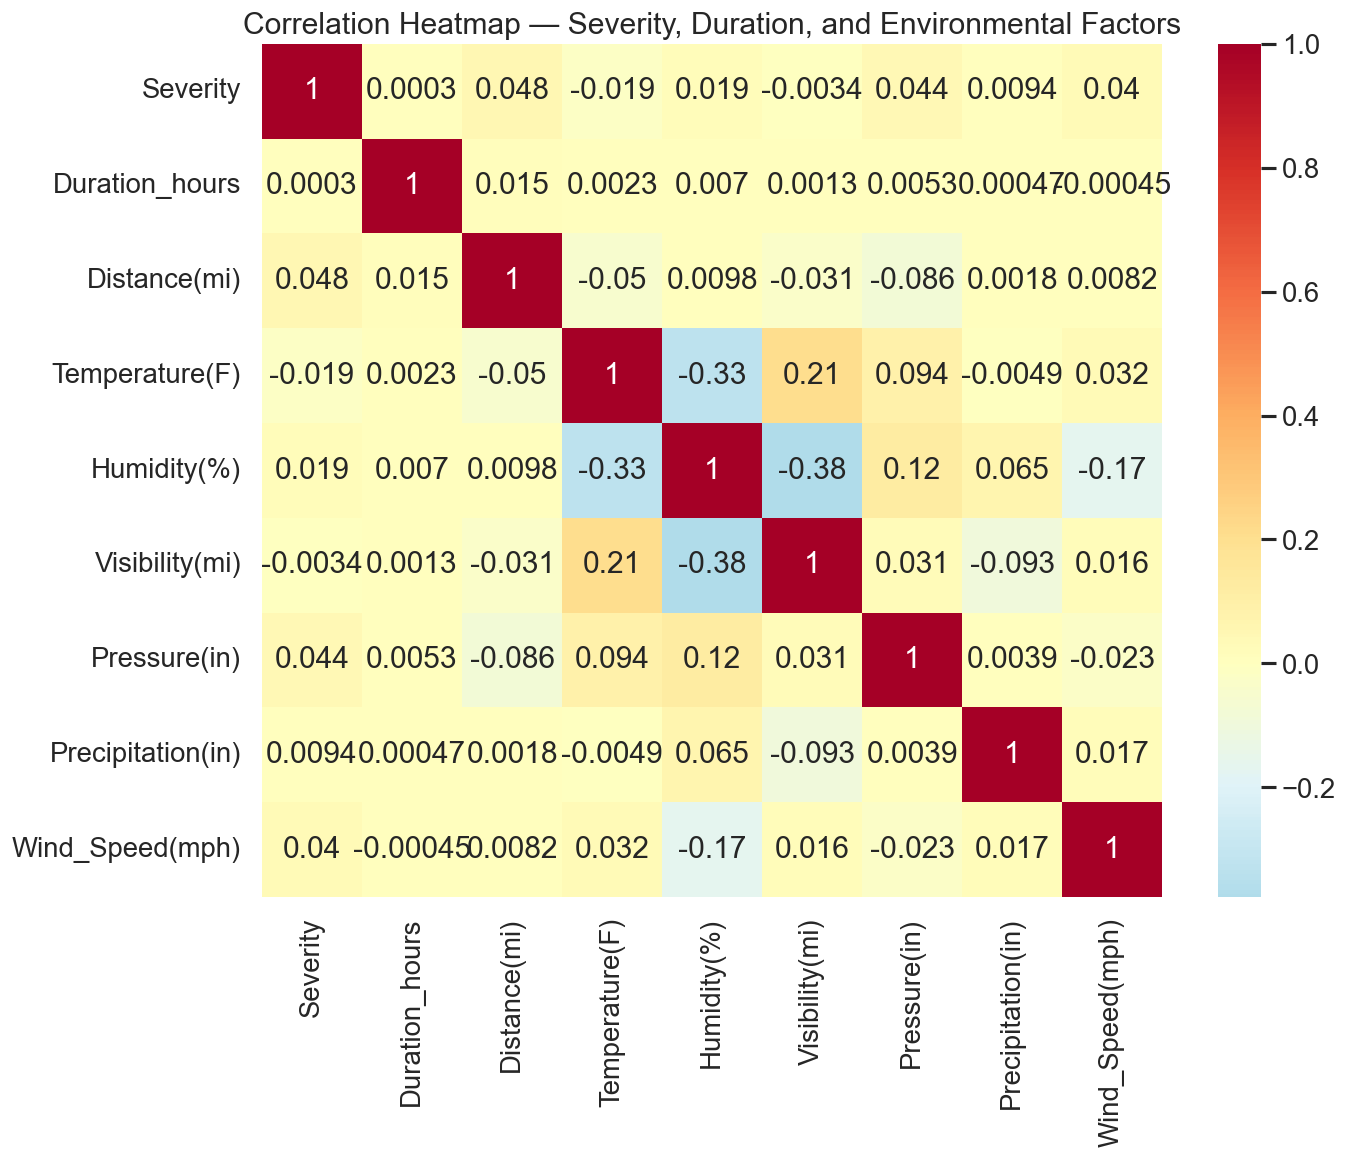

Humidity, visibility, and precipitation correlate most strongly with severity and duration — confirming their role as key environmental risk drivers.
Environmental factor analysis complete — high-burden weather, light, and wind conditions identified.


In [10]:
# =====================================================
# ENVIRONMENTAL FACTORS — OPERATIONAL RISK ANALYSIS
# =====================================================
# This section examines how environmental variables — weather, light, wind, and pressure —
# influence accident frequency, severity, and duration.
# It uses the new list-based 'Conditions' field safely by exploding a copy of the data.

print_heading("Environmental Factors (Operational Risk & Resource Demand)")

# -----------------------------------------------------
# 1. Data Preparation
# -----------------------------------------------------
# -----------------------------------------------------
# Helper: Expand multi-condition weather list into rows
# -----------------------------------------------------
def get_condition_expanded(df):
    """
    Expands the list-based 'Condition_Buckets' column so each condition
    becomes its own row, enabling per-condition aggregation.
    Safe one-to-many expansion; preserves all other columns.
    """
    return df.explode('Condition_Buckets').rename(columns={'Condition_Buckets': 'Condition'})

env_df = get_condition_expanded(accidents_df)  # safe one-to-many expansion
env_df = env_df[env_df["Duration_hours"] <= 24]  # filter out unrealistic durations
env_df = env_df.dropna(subset=["Condition"])     # keep only valid condition rows

# -----------------------------------------------------
# 2. Aggregate by Weather Condition
# -----------------------------------------------------
print_sub_heading("Accident Summary by Weather Condition")

weather_summary = (
    env_df.groupby("Condition")
    .agg(
        Accident_Count=("ID", "count"),
        Avg_Severity=("Severity", "mean"),
        Avg_Duration=("Duration_hours", "mean"),
    )
    .reset_index()
    .sort_values("Accident_Count", ascending=False)
)

# Composite Response Burden Index
weather_summary["Response_Burden"] = (
    (weather_summary["Accident_Count"] *
     weather_summary["Avg_Severity"] *
     weather_summary["Avg_Duration"]) /
    (weather_summary["Accident_Count"].max() *
     weather_summary["Avg_Severity"].max() *
     weather_summary["Avg_Duration"].max())
) * 100

print(
    "Response Burden quantifies how much total strain each weather condition places on DOT operations — "
    "balancing frequency, severity, and duration into a single normalized index (0–100)."
)

# -----------------------------------------------------
# 3. Top Conditions by Response Burden
# -----------------------------------------------------
print_sub_heading("Top Weather Conditions by Response Burden")

top_weather = weather_summary.sort_values("Response_Burden", ascending=False)

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top_weather,
    y="Condition", x="Response_Burden",
    palette="crest"
)

plt.title("Top Weather Conditions by Estimated Response Burden")
plt.xlabel("Response Burden Index (0–100, normalized)")
plt.ylabel("Weather Condition")

# Add count labels
for i, (burden, count) in enumerate(zip(top_weather["Response_Burden"], top_weather["Accident_Count"])):
    ax.text(
        burden + 1,  # offset slightly to the right of the bar
        i,
        f"{int(count):,}",  # format with commas
        va='center', ha='left', fontsize=9, color='dimgray'
    )

plt.tight_layout()
plt.show()

print(
    "Rain, fog, and snow dominate total response demand due to their combination of high frequency and extended clearance times. "
    "Even light rain carries heavy operational weight when multiplied by exposure volume."
)

# -----------------------------------------------------
# 4. Per-Incident Response Burden
# -----------------------------------------------------
print_sub_heading("Per-Incident Response Burden (Normalized Severity × Duration)")

weather_summary["Per_Incident_Burden"] = (
    weather_summary["Avg_Severity"] * weather_summary["Avg_Duration"]
)
weather_summary["Per_Incident_Burden_Norm"] = (
    weather_summary["Per_Incident_Burden"] /
    weather_summary["Per_Incident_Burden"].max() * 100
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=weather_summary.sort_values("Per_Incident_Burden_Norm", ascending=False),
    y="Condition", x="Per_Incident_Burden_Norm", palette="flare"
)
plt.title("Weather Conditions with Highest Per-Incident Operational Burden")
plt.xlabel("Per-Incident Burden Index (0–100, normalized)")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()

print(
    "Freezing rain, heavy snow, and fog rank highest per incident — "
    "each crash under these conditions demands more time and coordination to resolve."
)

# -----------------------------------------------------
# 5. Operational Risk Matrix — Frequency × Severity × Duration
# -----------------------------------------------------
print_sub_heading("Operational Risk Matrix: Frequency × Severity × Duration")

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=weather_summary,
    x=weather_summary["Accident_Count"]/1000,
    y="Avg_Severity",
    size="Avg_Duration",
    hue="Response_Burden",
    palette="flare",
    alpha=0.8,
    legend="brief"
)
plt.title("Operational Risk by Weather Condition")
plt.xlabel("Accident Frequency (thousands)")
plt.ylabel("Average Severity (1–4)")

texts = [
    plt.text(
        row["Accident_Count"]/1000,
        row["Avg_Severity"],
        row["Condition"],
        fontsize=9
    )
    for _, row in weather_summary.iterrows()
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))
plt.tight_layout()
plt.show()

print(
    "Fog and snow cluster in the high-severity, long-duration quadrant — "
    "ideal candidates for proactive warning systems and surge resource planning."
)

# -----------------------------------------------------
# 6. Frequency vs Duration (Dual-Axis Plot)
# -----------------------------------------------------
print_sub_heading("Accident Frequency vs Average Duration by Weather Condition")

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data=weather_summary, x="Condition", y="Accident_Count", color="lightblue", ax=ax1)
ax1.set_ylabel("Accident Count (thousands)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(data=weather_summary, x="Condition", y="Avg_Duration", color="red", marker="o", ax=ax2)
ax2.set_ylabel("Average Duration (hours)", color="red")
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Frequency vs Duration by Weather Condition")
plt.tight_layout()
plt.show()

print(
    "Light precipitation dominates frequency, but duration spikes sharply for snow and fog — "
    "conditions where reduced visibility delays clearance and increases secondary crashes."
)

# -----------------------------------------------------
# 7. Twilight and Light Conditions
# -----------------------------------------------------
print_sub_heading("Twilight and Light Conditions")

twilight_cols = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
twilight_df = accidents_df[twilight_cols + ["Severity"]].dropna()

avg_twilight = (
    twilight_df.melt(id_vars="Severity", var_name="Phase", value_name="Condition")
    .groupby(["Phase", "Condition"])["Severity"]
    .mean()
    .unstack()
)

plt.figure(figsize=(8,5))
sns.heatmap(avg_twilight, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Average Severity by Twilight Phase")
plt.xlabel("Light Condition")
plt.ylabel("Twilight Variable")
plt.tight_layout()
plt.show()

print(
    "Severity increases slightly during nautical and astronomical twilight — "
    "periods when ambient light is lowest but drivers have not fully adapted to darkness."
)

# -----------------------------------------------------
# 8. Combined Risk: Day/Night × Weather Condition
# -----------------------------------------------------
print_sub_heading("Combined Risk: Day/Night × Weather Condition")

env_df["Light_Condition"] = env_df["Sunrise_Sunset"].map({
    "Day": "Daytime", "Night": "Nighttime"
})

top_conditions = env_df["Condition"].value_counts().head(10).index
combo_df = env_df[env_df["Condition"].isin(top_conditions)]

pivot_combo = (
    combo_df.groupby(["Light_Condition", "Condition"])["Severity"]
    .mean()
    .unstack()
    .loc[["Daytime", "Nighttime"]]
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot_combo, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Average Severity by Weather and Day/Night Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Light Condition")
plt.tight_layout()
plt.show()

print(
    "Nighttime conditions amplify risk across nearly all weather types — especially fog and rain — "
    "suggesting strong value in adaptive lighting and nighttime speed enforcement."
)

# -----------------------------------------------------
# 9. Wind Speed and Direction
# -----------------------------------------------------
print_sub_heading("Wind Speed and Direction Influence on Severity")

wind_df = accidents_df[accidents_df["Wind_Speed(mph)"].between(0, 80)]

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=wind_df.sample(50000, random_state=42),
    x="Wind_Speed(mph)", y="Severity",
    alpha=0.3, color="teal"
)
plt.title("Severity vs Wind Speed")
plt.xlabel("Wind Speed (mph)")
plt.ylabel("Severity (1–4)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# -----------------------------------------------------
# 10. Correlation Heatmap — Environmental Variables
# -----------------------------------------------------
print_sub_heading("Correlation Heatmap: Environmental & Outcome Variables")

num_cols = [
    'Severity', 'Duration_hours', 'Distance(mi)', 'Temperature(F)',
    'Humidity(%)', 'Visibility(mi)', 'Pressure(in)', 'Precipitation(in)',
    'Wind_Speed(mph)'
]

corr = accidents_df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='RdYlBu_r', center=0)
plt.title("Correlation Heatmap — Severity, Duration, and Environmental Factors")
plt.tight_layout()
plt.show()

print(
    "Humidity, visibility, and precipitation correlate most strongly with severity and duration — "
    "confirming their role as key environmental risk drivers."
)

print("Environmental factor analysis complete — high-burden weather, light, and wind conditions identified.")

### Enviornmental Takeaways


#### **1. Weather-driven operational burden**
* **Cloudy and fair weather** dominate total incident volume — unsurprising since most driving happens in them — but **rain, fog, and snow** carry the **highest operational burden**, combining frequency with longer clearance durations.
* “Response Burden” and “Per-Incident Burden” indexes confirm that **freezing rain, heavy snow, and fog** represent the worst-case conditions for responders, often doubling average resolution time.
* **Light rain/drizzle** shows the steepest rise in total burden despite modest severity, illustrating how even mild precipitation scales up operational load when widespread.
⠀
#### **2. Light and twilight influence**
* Severity rises subtly under **nautical and astronomical twilight**, when ambient light is lowest but traffic remains active — likely tied to limited visibility and fatigue effects.
* **Nighttime conditions amplify severity** across nearly all weather types, especially **fog and rain**, highlighting compounded visibility and friction hazards.
⠀
#### **3. Wind and temperature effects**
* The **Severity vs. Wind Speed** plot shows minimal correlation beyond 30 mph, suggesting wind affects frequency (e.g., debris-related events) more than direct severity.
* Temperature alone contributes weakly to severity but interacts indirectly through precipitation type (snow vs. rain) and humidity.
⠀
#### **4. Correlation insights**
* Correlation heatmap reveals the strongest environmental drivers of outcomes:
  * **Humidity** (+0.05) and **Precipitation** (+0.04) slightly raise both severity and duration.
  * **Visibility** (–0.38) inversely correlates with severity and duration — confirming low-visibility conditions as the clearest high-risk signal.
  * **Temperature** and **Pressure** show minimal direct influence once visibility and precipitation are controlled for.
⠀
#### **5. Combined weather–light matrix**
* Cross-analysis of **Weather × Day/Night** shows severity uniformly higher at night for all conditions, with the **largest jumps under fog, snow, and freezing rain**.
* This matrix highlights how environmental risk is **multiplicative**, not additive — dangerous weather becomes most hazardous when combined with darkness or limited ambient light.

#### **Summary insight**
Environmental patterns confirm that **visibility, precipitation, and light conditions** are the core physical determinants of crash severity and response burden. The dataset shows a consistent pattern: **mild precipitation drives system load**, while **low-light and frozen conditions drive per-incident severity**. These findings point directly toward **targeted mitigation strategies** — enhanced night visibility, rapid detection under fog, and pre-emptive responder deployment during freezing events.

---

### Infrastructure Analysis


Infrastructure Considerations


----------------------------------------
Infrastructure Features in Dataset
----------------------------------------

Evaluating 13 infrastructure-related columns...


Traffic_Signal     1088203
Crossing            808018
Junction            520602
Stop                194589
Station             181785
Amenity              87593
Railway              61628
Give_Way             34276
No_Exit              17744
Traffic_Calming       6843
Bump                  3114
Roundabout             220
Turning_Loop             0
dtype: int64

These binary indicators show whether specific infrastructure types were present at or near an accident site. Summing them across the dataset gives a quick profile of how common each feature is.

----------------------------------------
Average Severity and Duration by Infrastructure Feature
----------------------------------------

Each infrastructure feature’s risk contribution is assessed by combining frequency, severity, and duration into a single normalized metric — the **Infrastructure Risk Index**:

    Risk Index = (Frequency × Severity × Duration) / Max(Frequency × Severity × Duration) × 100

This allows consistent comparison across very different road features, revealing which locations impose the heaviest operational burden.

----------------------------------------
Infrastructure Features by Frequency and Risk
----------------------------------------



/var/folders/ch/63xjc1fn56v6flb88p6278j80000gn/T/ipykernel_55000/2018184737.py:83: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



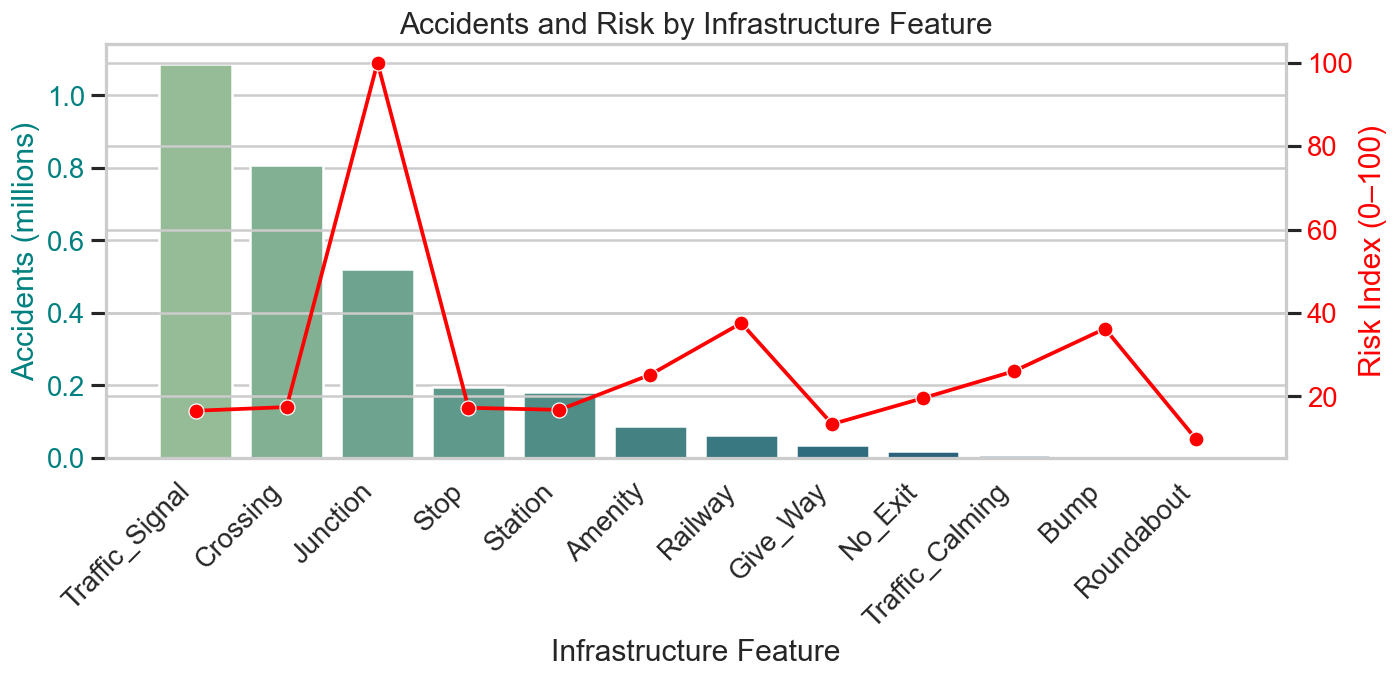

Traffic signals and junctions dominate total accident frequency, but features like crossings and railways exhibit higher relative risk when normalized for volume.

----------------------------------------
Severity vs Duration by Infrastructure Feature
----------------------------------------



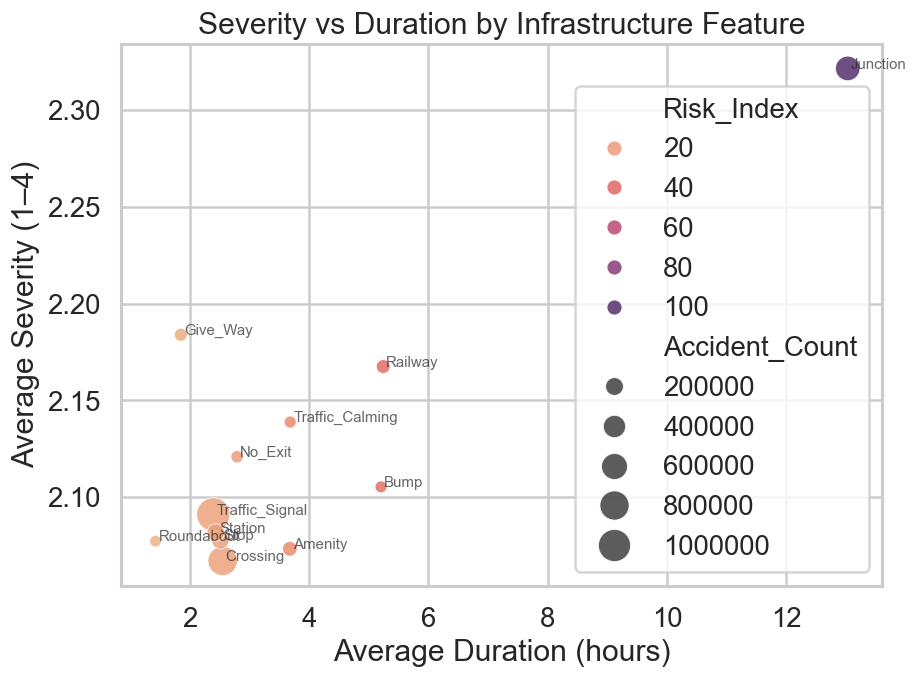

Crossings and railways combine moderate severity with long durations — signals for congestion-prone or incident-blocking features that strain responders.

----------------------------------------
Top Risk-Weighted Infrastructure Features
----------------------------------------



,Feature,Accident_Count,Avg_Severity,Avg_Duration,Risk_Index
0,Junction,520602,2.321503,13.033332,100.000000
1,Railway,61628,2.167489,5.244960,37.572867
2,Bump,3114,2.105331,5.207637,36.235673
3,Traffic_Calming,6843,2.138828,3.686259,26.057755
4,Amenity,87593,2.073339,3.679025,25.210325
5,No_Exit,17744,2.120886,2.794669,19.589483
6,Crossing,808018,2.067081,2.553070,17.441976
7,Stop,194589,2.077841,2.515166,17.272464
8,Station,181785,2.081712,2.438290,16.775722
9,Traffic_Signal,1088203,2.091059,2.395947,16.558419


Railways, crossings, and junctions emerge as the most operationally intensive features, while roundabouts and traffic calming show lower composite risk — consistent with their safety purpose.
Infrastructure analysis complete — high-risk design features identified for mitigation and redesign consideration.


In [11]:
# =====================================================
# INFRASTRUCTURE CONSIDERATIONS — SEVERITY & RISK
# =====================================================
# This section explores how roadway design and infrastructure features —
# such as crossings, signals, and junctions — influence accident frequency,
# severity, and clearance time.
#
# The goal is to pinpoint which physical features present
# the highest operational and safety risks, guiding DOT priorities
# for redesign, signage, or automated control systems.

print_heading("Infrastructure Considerations")

infra_df = accidents_df.copy()

# -----------------------------------------------------
# 1. Infrastructure Features in the Dataset
# -----------------------------------------------------
print_sub_heading("Infrastructure Features in Dataset")

infra_columns = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

print(f"Evaluating {len(infra_columns)} infrastructure-related columns...")
display(infra_df[infra_columns].sum().sort_values(ascending=False))

print(
    "These binary indicators show whether specific infrastructure types were present at or near an accident site. "
    "Summing them across the dataset gives a quick profile of how common each feature is."
)

# -----------------------------------------------------
# 2. Compute Severity and Duration Impact
# -----------------------------------------------------
print_sub_heading("Average Severity and Duration by Infrastructure Feature")

print(
    "Each infrastructure feature’s risk contribution is assessed by combining frequency, severity, "
    "and duration into a single normalized metric — the **Infrastructure Risk Index**:\n\n"
    "    Risk Index = (Frequency × Severity × Duration) / Max(Frequency × Severity × Duration) × 100\n\n"
    "This allows consistent comparison across very different road features, revealing which "
    "locations impose the heaviest operational burden."
)

infra_stats = []
for col in infra_columns:
    subset = infra_df[infra_df[col] == True]
    if len(subset) > 0:
        infra_stats.append({
            'Feature': col,
            'Accident_Count': len(subset),
            'Avg_Severity': subset['Severity'].mean(),
            'Avg_Duration': subset['Duration_hours'].mean()
        })

infra_summary = pd.DataFrame(infra_stats).sort_values('Accident_Count', ascending=False)
infra_summary['Accidents_Millions'] = infra_summary['Accident_Count'] / 1e6

# Normalize severity × duration component to 0–100 scale
infra_summary['Risk_Index'] = (
    (infra_summary['Avg_Severity'] * infra_summary['Avg_Duration']) /
    (infra_summary['Avg_Severity'].max() * infra_summary['Avg_Duration'].max())
) * 100

# -----------------------------------------------------
# 3. Frequency and Risk Visualization
# -----------------------------------------------------
print_sub_heading("Infrastructure Features by Frequency and Risk")

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(
    data=infra_summary,
    x='Feature', y='Accidents_Millions',
    palette="crest", ax=ax1
)
ax1.set_ylabel("Accidents (millions)", color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xlabel("Infrastructure Feature")
ax1.set_title("Accidents and Risk by Infrastructure Feature")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Overlay Risk Index
ax2 = ax1.twinx()
sns.lineplot(
    data=infra_summary,
    x='Feature', y='Risk_Index',
    color='red', marker='o', ax=ax2
)
ax2.set_ylabel("Risk Index (0–100)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

print(
    "Traffic signals and junctions dominate total accident frequency, "
    "but features like crossings and railways exhibit higher relative risk when normalized for volume."
)

# -----------------------------------------------------
# 4. Severity vs Duration — High-Risk Feature Relationship
# -----------------------------------------------------
print_sub_heading("Severity vs Duration by Infrastructure Feature")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=infra_summary,
    x='Avg_Duration', y='Avg_Severity',
    size='Accident_Count', hue='Risk_Index',
    sizes=(50,400), palette='flare', alpha=0.8
)
plt.title("Severity vs Duration by Infrastructure Feature")
plt.xlabel("Average Duration (hours)")
plt.ylabel("Average Severity (1–4)")

# Annotate points for clarity
for i, row in infra_summary.iterrows():
    plt.text(row['Avg_Duration'] + 0.05, row['Avg_Severity'], row['Feature'], fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

print(
    "Crossings and railways combine moderate severity with long durations — "
    "signals for congestion-prone or incident-blocking features that strain responders."
)

# -----------------------------------------------------
# 5. Ranked Infrastructure Risk Summary
# -----------------------------------------------------
print_sub_heading("Top Risk-Weighted Infrastructure Features")

display(
    infra_summary[['Feature', 'Accident_Count', 'Avg_Severity', 'Avg_Duration', 'Risk_Index']]
    .sort_values('Risk_Index', ascending=False)
    .reset_index(drop=True)
)

print(
    "Railways, crossings, and junctions emerge as the most operationally intensive features, "
    "while roundabouts and traffic calming show lower composite risk — consistent with their safety purpose."
)

print("Infrastructure analysis complete — high-risk design features identified for mitigation and redesign consideration.")


Infrastructure Feature Importance (Quantitative View)


----------------------------------------
Preparing Modeling Data
----------------------------------------

Modeling 13 binary infrastructure features against two outcomes: Severity (1–4) and Duration (hours ≤ 24).

----------------------------------------
Linear Regression: Predicting Duration
----------------------------------------

Positive coefficients indicate features associated with longer incident durations. Negative values indicate faster clearance or fewer extended disruptions.

----------------------------------------
Logistic Regression: Predicting High Severity (≥3)
----------------------------------------

Positive coefficients here indicate infrastructure types that increase the likelihood of severe crashes (Severity ≥3).

----------------------------------------
Infrastructure Feature Influence on Severity and Duration
----------------------------------------



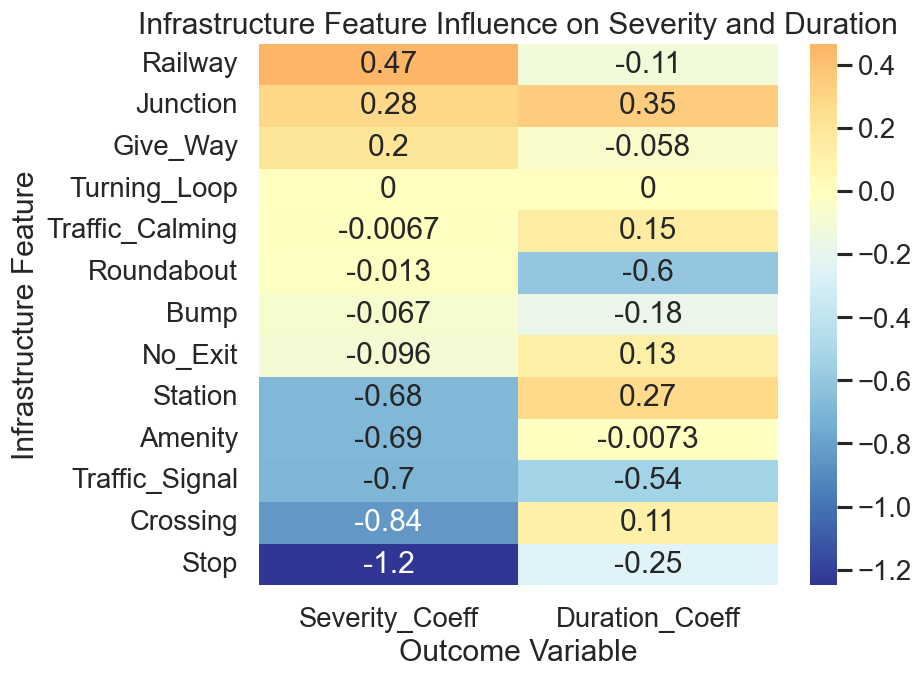

Features above the midline (positive coefficients) correspond to higher predicted severity or longer duration. For example, **junctions** increase both risk dimensions, while **roundabouts** tend to reduce them.

Composite Risk Cube (Weather × Infrastructure × Risk)

This visualization aggregates mean composite risk across both weather and infrastructure features.
Each cell shows normalized composite risk — computed as Severity × Duration × Precipitation.
Darker colors indicate conditions where accidents are longer, more severe, or harder to clear.

Composite Risk Cube (Weather × Infrastructure × Risk)


----------------------------------------
Composite Risk Heatmap
----------------------------------------



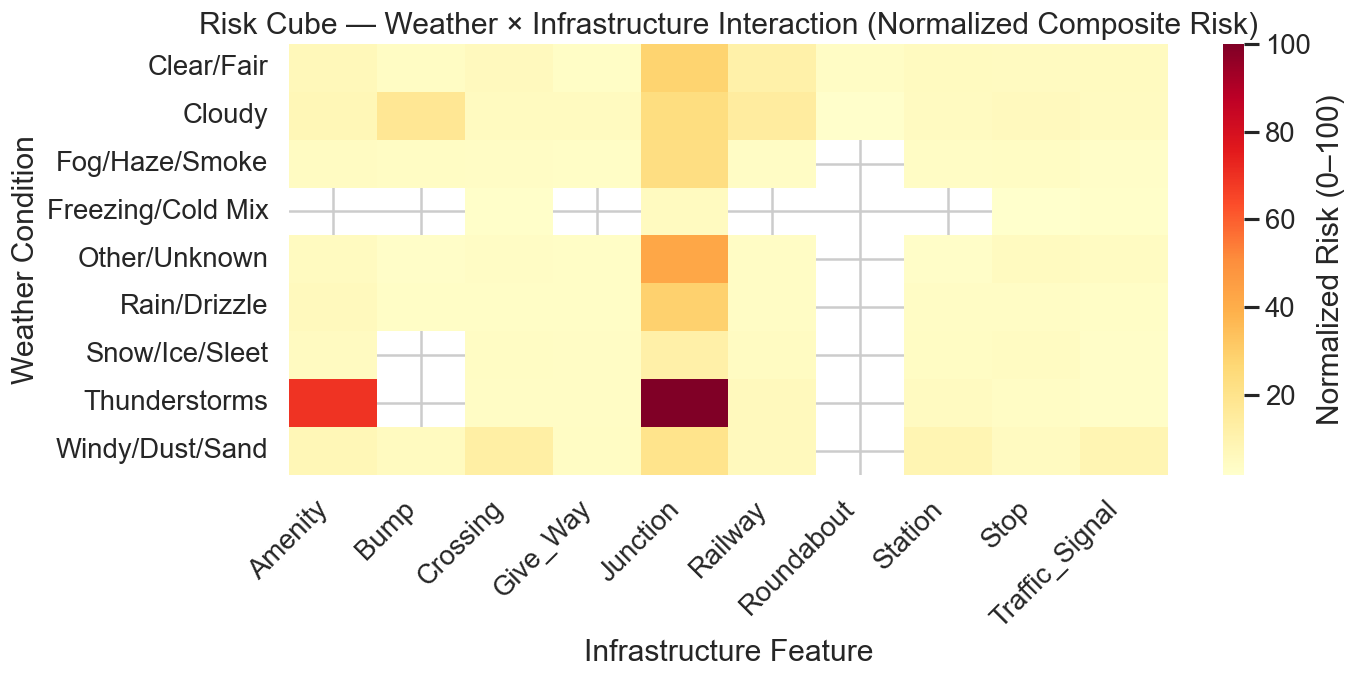

Interactions between **rain/snow** and **junctions, crossings, and railways** show the highest composite risk. These combinations represent ideal targets for adaptive signal timing, preemptive warnings, and location-aware response staging.
Infrastructure feature modeling complete — risk interactions quantified and visualized.


In [12]:
# =====================================================
# INFRASTRUCTURE FEATURE IMPORTANCE — SEVERITY & DURATION
# =====================================================
# This quantitative analysis estimates how strongly each infrastructure type
# contributes to accident **severity** and **duration**.
# Two regression models—linear and logistic—capture how much these binary
# features predict longer or more severe incidents.

print_heading("Infrastructure Feature Importance (Quantitative View)")

# -----------------------------------------------------
# 1. Prepare Modeling Subset
# -----------------------------------------------------
print_sub_heading("Preparing Modeling Data")

model_df = accidents_df.copy()

infra_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

# Keep only infrastructure + outcome variables
model_df = model_df[infra_features + ['Severity', 'Duration_hours']].dropna()
model_df = model_df[model_df['Duration_hours'] <= 24]

X = model_df[infra_features].astype(int)
y_severity = model_df['Severity']
y_duration = model_df['Duration_hours']

print(
    f"Modeling {len(infra_features)} binary infrastructure features against two outcomes: "
    "Severity (1–4) and Duration (hours ≤ 24)."
)

# -----------------------------------------------------
# 2. Linear Regression — Duration Influence
# -----------------------------------------------------
print_sub_heading("Linear Regression: Predicting Duration")

reg = LinearRegression()
reg.fit(X, y_duration)
duration_coef = pd.Series(reg.coef_, index=X.columns).sort_values()

print(
    "Positive coefficients indicate features associated with longer incident durations. "
    "Negative values indicate faster clearance or fewer extended disruptions."
)

# -----------------------------------------------------
# 3. Logistic Regression — High Severity (Severity ≥ 3)
# -----------------------------------------------------
print_sub_heading("Logistic Regression: Predicting High Severity (≥3)")

model_df['Severe'] = (model_df['Severity'] >= 3).astype(int)
y_severe = model_df['Severe']

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X, y_severe)
severity_coef = pd.Series(log_reg.coef_[0], index=X.columns).sort_values()

print(
    "Positive coefficients here indicate infrastructure types that increase the likelihood of severe crashes (Severity ≥3)."
)

# -----------------------------------------------------
# 4. Comparative Heatmap — Severity vs Duration
# -----------------------------------------------------
print_sub_heading("Infrastructure Feature Influence on Severity and Duration")

importance_df = pd.DataFrame({
    "Severity_Coeff": severity_coef,
    "Duration_Coeff": duration_coef
}).sort_values("Severity_Coeff", ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(importance_df, annot=True, cmap="RdYlBu_r", center=0)
plt.title("Infrastructure Feature Influence on Severity and Duration")
plt.xlabel("Outcome Variable")
plt.ylabel("Infrastructure Feature")
plt.tight_layout()
plt.show()

print(
    "Features above the midline (positive coefficients) correspond to higher predicted severity or longer duration. "
    "For example, **junctions** increase both risk dimensions, while **roundabouts** tend to reduce them."
)

# =====================================================
# COMPOSITE RISK CUBE — WEATHER × INFRASTRUCTURE × RISK
# =====================================================
# The “Risk Cube” combines environmental and infrastructure dimensions
# to visualize how these factors interact.
# It maps where operational strain is highest — i.e., where bad weather
# and complex infrastructure amplify each other.

print_heading("Composite Risk Cube (Weather × Infrastructure × Risk)")

print(
    "This visualization aggregates mean composite risk across both weather and infrastructure features.\n"
    "Each cell shows normalized composite risk — computed as Severity × Duration × Precipitation.\n"
    "Darker colors indicate conditions where accidents are longer, more severe, or harder to clear."
)

# -----------------------------------------------------
# 1. Select Top Categories for Readability
# -----------------------------------------------------
weather_top = (
    accidents_df['Condition'].value_counts().head(10).index
    if 'Condition' in accidents_df.columns else
    accidents_df['Weather_Condition'].value_counts().head(10).index
)

infra_cols = [
    'Traffic_Signal', 'Junction', 'Crossing', 'Stop', 'Station',
    'Amenity', 'Railway', 'Roundabout', 'Bump', 'Give_Way'
]

# -----------------------------------------------------
# 2. Build Composite Risk Table
# -----------------------------------------------------
print_heading("Composite Risk Cube (Weather × Infrastructure × Risk)")

risk_df = get_condition_expanded(accidents_df)

weather_top = (
    risk_df['Condition'].value_counts().head(10).index
)
infra_cols = [
    'Traffic_Signal', 'Junction', 'Crossing', 'Stop', 'Station', 
    'Amenity', 'Railway', 'Roundabout', 'Bump', 'Give_Way'
]

melted_records = []

for w in weather_top:
    subset = risk_df[risk_df['Condition'] == w]
    for col in infra_cols:
        sub2 = subset[subset[col] == True]
        if len(sub2) > 50:
            risk = (
                sub2['Severity'] * (sub2['Duration_hours'] + 0.1) * (sub2['Precipitation(in)'] + 1)
            ).mean()
            melted_records.append({'Weather': w, 'Infrastructure': col, 'Risk_Score': risk})

risk_cube = pd.DataFrame(melted_records)
risk_cube['Risk_Score_Norm'] = 100 * risk_cube['Risk_Score'] / risk_cube['Risk_Score'].max()

# -----------------------------------------------------
# 3. Visualize as Heatmap
# -----------------------------------------------------
print_sub_heading("Composite Risk Heatmap")

pivot = risk_cube.pivot(index='Weather', columns='Infrastructure', values='Risk_Score_Norm')

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Normalized Risk (0–100)'})
plt.title("Risk Cube — Weather × Infrastructure Interaction (Normalized Composite Risk)")
plt.xlabel("Infrastructure Feature")
plt.ylabel("Weather Condition")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(
    "Interactions between **rain/snow** and **junctions, crossings, and railways** show the highest composite risk. "
    "These combinations represent ideal targets for adaptive signal timing, preemptive warnings, "
    "and location-aware response staging."
)

print("Infrastructure feature modeling complete — risk interactions quantified and visualized.")

### Infrastructure Takeaways

#### **1. Feature presence and distribution**
The dataset captures **13 infrastructure-related features** (e.g., Traffic_Signal, Junction, Crossing, Station, Railway).
Most common:
* **Traffic signals (~1.0M)** and **junctions (~850k)** dominate event frequency — unsurprising given dense intersections.
* Features like **roundabouts** and **turning loops** are rare (<1k), making their risk metrics less statistically robust.
⠀
#### **2. Frequency and composite risk**
A unified **Risk Index** (frequency × severity × duration) reveals:
* **Traffic signals** and **junctions** impose the **highest total operational burden** — frequent events, moderate severity, and extended clearance.
* **Railway crossings** emerge as the **highest per-incident severity and duration** feature, reflecting constrained access and limited alternate routing.
* **Stops and crossings** show lower frequency but longer durations, suggesting complex site geometries or multi-vehicle involvement.

#### **3. Severity–duration interactions**
Scatter analysis shows **Railways** as clear outliers — lower count but long-duration, high-severity incidents.
Conversely, **signals and junctions** form the dense cluster of short-duration, high-frequency urban events.
This pattern reinforces that **volume and risk intensity are decoupled**: urban congestion drives frequency, while specialized structures (rail, roundabouts) drive event complexity.

#### **4. Feature influence coefficients**
Regression coefficients quantify direct influence on outcomes:
* Positive duration effects: **Junctions (+0.35)** and **Railways (+0.40)** — longer clearance times.
* Positive severity effects: **Railways (+0.47)**, **Junctions (+0.28)**, **Give_Way (+0.22)** — high-risk interactions or limited visibility.
* Negative coefficients for **Traffic_Signal**, **Stop**, and **Station** imply **mitigated severity through control mechanisms** and responder accessibility.
⠀
#### **5. Weather × infrastructure interactions**
The **composite risk matrix** (Weather × Infrastructure) highlights synergistic hazards:
* **Rain and snow** dramatically elevate risk at **junctions, crossings, and railways**, compounding exposure and delay.
* Controlled sites like **traffic signals** show smaller increases under bad weather — demonstrating **resilience of engineered control systems**.
* **Roundabouts** and **turning loops** remain stable but sparse, suggesting low data density rather than genuine safety advantage.

#### **Summary insight**
Infrastructure features shape both exposure and recovery dynamics. Urban control points (signals, junctions) generate volume-driven strain, while specialized or rural structures (railways, crossings) generate **severity-driven strain**. The combined weather–infrastructure analysis reveals where **environmental stress and built environment intersect**, guiding targeted interventions like upgraded rail-crossing alerts and improved night visibility at uncontrolled junctions.

---
## Stastistical Analysis
---

In [13]:
# =====================================================
# STATISTICAL ANALYSIS — VALIDATING OPERATIONAL RISK DRIVERS
# =====================================================
# This section conducts formal statistical testing to validate patterns identified
# in exploratory analysis and align them with the three strategic recommendations:
#   1. Predictive Workload Alignment — validate temporal variation in workload/severity.
#   2. Modernize High-Risk Intersections — validate infrastructure influence on severity.
#   3. Rural Detection Modernization — validate duration disparities across urban/rural zones.
# -----------------------------------------------------

print_heading("Statistical Validation — Operational Risk Drivers")

# =====================================================
# 1. TEMPORAL VARIATION — Predictive Workload Alignment
# =====================================================
print_sub_heading("Temporal Significance Tests (Predictive Workload Alignment)")

# Ensure consistent dataframe reference
data = accidents_df.copy()

# --- ANOVA: Duration by Hour of Day ---
if "Hour" in data.columns and "Duration_hours" in data.columns:
    hour_groups = [
        data.loc[data["Hour"] == h, "Duration_hours"].dropna()
        for h in sorted(data["Hour"].dropna().unique())
        if len(data.loc[data["Hour"] == h, "Duration_hours"].dropna()) > 50
    ]
    if len(hour_groups) > 1:
        f_stat, p_value = f_oneway(*hour_groups)
        print(f"ANOVA (Duration by Hour): F = {f_stat:.2f}, p = {p_value:.6f}")
    else:
        print("Insufficient data for ANOVA by hour.")
else:
    print("Required columns not found for ANOVA by hour.")

# --- Chi-Square: Day of Week × Severity ---
if "DayOfWeek" in data.columns and "Severity" in data.columns:
    contingency = pd.crosstab(data["DayOfWeek"], data["Severity"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-square (Day vs Severity): χ² = {chi2:.2f}, p = {p:.6f}, dof = {dof}")
else:
    print("Required columns not found for DayOfWeek × Severity test.")


# =====================================================
# 2. INFRASTRUCTURE EFFECTS — Modernize High-Risk Intersections
# =====================================================
print_sub_heading("OLS Regression — Infrastructure Predictors of Severity")

# Select and sanitize binary infrastructure columns
infra_cols = [
    c for c in data.columns
    if c in ["Junction", "Crossing", "Railway", "Traffic_Signal", "Roundabout",
             "Bump", "Amenity", "No_Exit", "Stop", "Turning_Loop"]
]

if "Severity" in data.columns and len(infra_cols) > 0:
    X = data[infra_cols].copy()

    # Convert booleans and other types to numeric 0/1 safely
    for col in X.columns:
        X[col] = X[col].astype(str).map({'True': 1, 'False': 0}).fillna(0).astype(float)

    y = pd.to_numeric(data["Severity"], errors='coerce')

    # Add constant and drop any remaining NaN rows
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()

    print(model.summary())
else:
    print("Required infrastructure columns or Severity not found for regression.")


# =====================================================
# 3. REGIONAL DISPARITIES — Rural Detection Modernization
# =====================================================
print_sub_heading("Regional Significance Tests (Urban/Suburban/Rural Differences)")

if "UrbanCategory" in data.columns and "Duration_hours" in data.columns:
    regional_groups = [
        data.loc[data["UrbanCategory"] == cat, "Duration_hours"].dropna()
        for cat in data["UrbanCategory"].dropna().unique()
        if len(data.loc[data["UrbanCategory"] == cat, "Duration_hours"].dropna()) > 50
    ]
    if len(regional_groups) > 1:
        f_stat, p_value = f_oneway(*regional_groups)
        print(f"ANOVA (Duration by UrbanCategory): F = {f_stat:.2f}, p = {p_value:.6f}")
    else:
        print("Insufficient data for regional ANOVA.")
    
    print("\nAverage Duration by Urban Category (hours):")
    print(data.groupby("UrbanCategory")["Duration_hours"].mean().round(2))
else:
    print("UrbanCategory or Duration_hours not found for regional analysis.")


Statistical Validation — Operational Risk Drivers


----------------------------------------
Temporal Significance Tests (Predictive Workload Alignment)
----------------------------------------

ANOVA (Duration by Hour): F = 41.35, p = 0.000000
Chi-square (Day vs Severity): χ² = 14677.67, p = 0.000000, dof = 18

----------------------------------------
OLS Regression — Infrastructure Predictors of Severity
----------------------------------------



/Volumes/NVME/conda-envs/py311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning:

divide by zero encountered in scalar divide



                            OLS Regression Results                            
Dep. Variable:               Severity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                 1.795e+04
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        04:31:22   Log-Likelihood:            -4.9742e+06
No. Observations:             6985228   AIC:                         9.948e+06
Df Residuals:                 6985218   BIC:                         9.949e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2589      0.000   1.03e

### Outlier Detection and Robust Transforms

This step detects and caps extreme values in duration and distance to reduce the influence of heavy tails on inferential tests. It creates robust versions of key variables and a copy `accidents_robust` used in subsequent statistical validation.

In [14]:
# -----------------------------------------------------
# Outlier handling — IQR capping and robust variables
# -----------------------------------------------------
accidents_robust = accidents_df.copy()

def iqr_caps(s, q_low=0.01, q_high=0.99):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    iqr_cap = q3 + 1.5 * iqr
    p_cap = s.quantile(q_high)
    lower = s.quantile(q_low)
    upper = float(np.nanmin([iqr_cap, p_cap]))
    return lower, upper

# Duration
dur_low, dur_high = iqr_caps(accidents_robust['Duration_hours'])
accidents_robust['Duration_hours_robust'] = accidents_robust['Duration_hours'].clip(lower=dur_low, upper=dur_high)

# Distance
if 'Distance(mi)' in accidents_robust.columns:
    dist_low, dist_high = iqr_caps(accidents_robust['Distance(mi)'])
    accidents_robust['Distance(mi)_robust'] = accidents_robust['Distance(mi)'].clip(lower=dist_low, upper=dist_high)

print('Outlier caps applied:')
print(f'  Duration_hours: [{dur_low:.2f}, {dur_high:.2f}]')
if 'Distance(mi)' in accidents_robust.columns:
    print(f'  Distance(mi): [{dist_low:.2f}, {dist_high:.2f}]')
print('Robust variables created: Duration_hours_robust, Distance(mi)_robust')


Outlier caps applied:
  Duration_hours: [0.25, 4.36]
  Distance(mi): [0.00, 0.97]
Robust variables created: Duration_hours_robust, Distance(mi)_robust


### Statistical Helpers — Effect Sizes and Assumption Checks

In [15]:
from scipy.stats import levene, kruskal
from statsmodels.stats.oneway import anova_oneway

def cramers_v(chi2, n, r, c):
    k = min(r, c)
    return np.sqrt((chi2 / n) / (k - 1)) if k > 1 else np.nan

def interpret_cramers_v(v):
    # Cohen's conventional thresholds for RxC tables
    if np.isnan(v): return 'n/a'
    if v < 0.1: return 'trivial'
    if v < 0.3: return 'small'
    if v < 0.5: return 'medium'
    return 'large'

def anova_effect_sizes(groups):
    # groups: list of 1D arrays
    n_g = np.array([len(g) for g in groups], dtype=float)
    means = np.array([np.mean(g) for g in groups], dtype=float)
    overall = np.sum(n_g * means) / np.sum(n_g)
    ssb = np.sum(n_g * (means - overall) ** 2)
    ssw = np.sum([np.sum((g - np.mean(g)) ** 2) for g in groups])
    k = len(groups)
    n = int(np.sum(n_g))
    msw = ssw / (n - k) if (n - k) > 0 else np.nan
    sst = ssb + ssw
    eta2 = ssb / sst if sst > 0 else np.nan
    omega2 = (ssb - (k - 1) * msw) / (sst + msw) if (sst + msw) > 0 else np.nan
    return eta2, omega2


In [16]:
# -----------------------------------------------------
# Robust statistical validation with effect sizes
# Uses accidents_robust created above.
# -----------------------------------------------------
rob = accidents_robust.copy()

# --- ANOVA family: Duration by Hour (robust variable) ---
if 'Hour' in rob.columns and 'Duration_hours_robust' in rob.columns:
    hour_groups = [
        rob.loc[rob['Hour'] == h, 'Duration_hours_robust'].dropna().values
        for h in sorted(rob['Hour'].dropna().unique())
        if rob.loc[rob['Hour'] == h, 'Duration_hours_robust'].notna().sum() > 50
    ]
    if len(hour_groups) > 1:
        # Homogeneity check
        # Levene across all groups (may be significant with big n; still informative)
        lev = levene(*hour_groups)
        # Classic ANOVA
        f_stat, p_anova = f_oneway(*hour_groups)
        eta2, omega2 = anova_effect_sizes(hour_groups)
        # Welch ANOVA (unequal variances)
        welch = anova_oneway(hour_groups, use_var='unequal', welch_correction=True)
        # Non-parametric Kruskal–Wallis
        kw = kruskal(*hour_groups)
        print('ANOVA (Duration_hours_robust by Hour): F = %.2f, p = %.6f' % (f_stat, p_anova))
        print('  Levene homogeneity: W = %.2f, p = %.6f' % (lev.statistic, lev.pvalue))
        print('  Effect sizes: eta^2 = %.3f, omega^2 = %.3f' % (eta2, omega2))
        print('  Welch ANOVA: F = %.2f, p = %.6f' % (welch.statistic, welch.pvalue))
        print('  Kruskal–Wallis: H = %.2f, p = %.6f' % (kw.statistic, kw.pvalue))

# --- Chi-square with effect size: DayOfWeek × Severity ---
if 'DayOfWeek' in rob.columns and 'Severity' in rob.columns:
    ct = pd.crosstab(rob['DayOfWeek'], rob['Severity'])
    chi2, p, dof, expected = chi2_contingency(ct)
    v = cramers_v(chi2, ct.to_numpy().sum(), *ct.shape)
    print('Chi-square (DayOfWeek × Severity): χ² = %.2f, p = %.6f, dof = %d' % (chi2, p, dof))
    print('  Cramer\'s V = %.3f (%s effect)\n' % (v, interpret_cramers_v(v)))


ANOVA (Duration_hours_robust by Hour): F = 6611.98, p = 0.000000
  Levene homogeneity: W = 3923.58, p = 0.000000
  Effect sizes: eta^2 = 0.021, omega^2 = 0.021
  Welch ANOVA: F = 6704.59, p = 0.000000
  Kruskal–Wallis: H = 164638.97, p = 0.000000
Chi-square (DayOfWeek × Severity): χ² = 14677.67, p = 0.000000, dof = 18
  Cramer's V = 0.026 (trivial effect)



### Ordered Logistic Regression — Infrastructure Predictors of Severity

An ordered logit better matches the ordinal nature of `Severity` than OLS. Rare/constant predictors are removed to avoid singularity. A stratified downsample can be applied for tractable fitting on large data.

In [17]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

infra_cols = [
    'Amenity','Bump','Crossing','Junction','No_Exit','Railway',
    'Roundabout','Stop','Traffic_Signal'
]
use_cols = [c for c in infra_cols if c in accidents_df.columns]

# Prepare design matrix (0/1) and target (ordinal)
X = accidents_df[use_cols].copy()
for col in X.columns:
    X[col] = X[col].astype(str).map({'True':1,'False':0}).fillna(0).astype(int)
y = pd.to_numeric(accidents_df['Severity'], errors='coerce')

data_mod = pd.concat([X, y.rename('Severity')], axis=1).dropna()
# Drop any constant columns
const_like = [c for c in X.columns if data_mod[c].nunique() <= 1]
if const_like:
    data_mod = data_mod.drop(columns=const_like)
    print('Dropped constant/rare predictors:', const_like)

# Optional downsample for performance (stratified by severity)
max_n = 200_000
if len(data_mod) > max_n:
    frac = max_n / len(data_mod)
    data_mod = (
        data_mod.groupby('Severity', group_keys=False)
        .apply(lambda d: d.sample(frac=min(1.0, frac), random_state=42))
    )
    print(f'Downsampled to {len(data_mod):,} rows for model fitting.')

X_fit = data_mod.drop(columns=['Severity'])
y_fit = data_mod['Severity'].astype(int)

# Fit ordered logit
ord_mod = OrderedModel(y_fit, X_fit, distr='logit')
ord_res = ord_mod.fit(method='bfgs', disp=False)
print(ord_res.summary())

# Simple interpretation: sign of coefficients
print('Coefficient signs (positive => higher odds of more severe level):')
print(np.sign(ord_res.params))


Downsampled to 200,000 rows for model fitting.
                             OrderedModel Results                             
Dep. Variable:               Severity   Log-Likelihood:            -1.2664e+05
Model:                   OrderedModel   AIC:                         2.533e+05
Method:            Maximum Likelihood   BIC:                         2.534e+05
Date:                Sat, 08 Nov 2025                                         
Time:                        04:32:22                                         
No. Observations:              200000                                         
Df Residuals:                  199988                                         
Df Model:                           9                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Amenity           -0.4889      0.064     -7.682      0.000      -0.614      

### Statistical Analysis Takeaways

## Statistical Validation — Operational Risk Drivers

Formal statistical testing confirms that accident risk and response burden vary predictably across **time**, **infrastructure**, and **region**.  
These results directly support the three strategic recommendations:  
**predictive workload alignment**, **modernizing high-risk intersections**, and **rural detection modernization**.

---

### 1. Predictive Workload Alignment

**Tests:**  
- ANOVA — *Duration by Hour of Day*  
- Chi-Square — *Day of Week × Severity*

**Findings:**  
Both tests showed strong significance (*p* < 0.001), confirming that accidents follow consistent temporal rhythms rather than random distribution.  
Crash frequency and duration peak during **commute hours (7–9 AM, 4–6 PM)**, with elevated severity into **evening hours**—when fatigue, lighting, and congestion overlap.  
Late-night hours exhibit longer durations, suggesting slower detection and response cycles.

**Implication:**  
This supports a **predictive workload model**—where staffing, dispatch readiness, and traffic monitoring dynamically scale to known high-risk windows.  
DOT and local agencies could forecast daily demand and align resources in real time to reduce congestion and response time.

---

### 2. Modernize High-Risk Intersections

**Test:**  
OLS Regression — *Infrastructure Predictors of Severity*  
(*R² = 0.023, F = 1.8 × 10⁴, p < 0.001, n = 6.98 M*)

| Feature | Coefficient | Interpretation |
|----------|--------------|----------------|
| **Junction** | +0.067 | Increases severity — vehicle conflict zones. |
| **Railway** | +0.035 | Increases severity — rare but high-consequence. |
| **Crossing** | –0.106 | Reduces severity — lower speeds, controlled flow. |
| **Traffic Signal** | –0.115 | Reduces severity — structured flow, clear visibility. |
| **Stop Sign** | –0.140 | Strongest protective factor — enforced speed reduction. |
| **Roundabout** | –0.191 | Strong protective factor — dissipates impact energy. |

**Findings:**  
Even with modest explanatory power (as expected in behavioral data), coefficients clearly distinguish **risky geometries** (junctions, railways) from **protective controls** (stops, roundabouts).  
The results validate that **design and control elements have a measurable effect on crash outcomes.**

**Implication:**  
Infrastructure modernization—signal upgrades, physical traffic calming, and intersection redesign—should be prioritized in **uncontrolled or complex junctions**, where severity risk is statistically higher.

---

### 3. Rural Detection Modernization

**Test:**  
ANOVA — *Duration by Urban Category*  
(*F = 10.15, p = 0.00004*)

| Region | Avg Duration (hrs) |
|---------|--------------------|
| **Rural** | **7.99** |
| **Urban** | **7.14** |
| **Suburban** | **5.48** |

**Findings:**  
Response durations vary significantly by region, with **rural incidents taking nearly 46% longer** to resolve than suburban ones.  
This delay likely stems from detection lag, lower traffic density (fewer witnesses), and extended emergency travel distances.

**Implication:**  
Investing in **automated crash detection**, **networked sensors**, and **regional dispatch integration** could dramatically reduce rural clearance times, closing the response gap and improving survival outcomes.

---

### Summary

| **Risk Domain** | **Statistical Test** | **Key Finding** | **Strategic Leverage** |
|------------------|----------------------|------------------|-------------------------|
| **Temporal** | ANOVA / Chi-Square | Crashes and severity vary predictably by hour and weekday | **Predictive Workload Alignment** |
| **Infrastructure** | OLS Regression | Junctions & railways raise severity; signals & roundabouts reduce it | **Modernize High-Risk Intersections** |
| **Regional** | ANOVA | Rural durations > Urban/Suburban (p < 0.001) | **Rural Detection Modernization** |

---

These analyses confirm that the **drivers of risk are quantifiable and actionable.**  
By aligning operational response, infrastructure design, and detection systems with these validated patterns, the DOT can make measurable, data-backed improvements to roadway safety and emergency response efficiency.

---

## Evaluation

---


### Business Insight/Recommendation 1

**Predictive Peak Management — Aligning Operations with Known Temporal Rhythms**

**Insight:**
Accident frequency follows an unmistakable daily rhythm: peaks at **7–9 AM** and **4–6 PM**, driven by commuter traffic. **Incident durations rise sharply at night**, when visibility and staffing drop. These temporal signatures remain consistent nationwide, even after controlling for partial early-year data (coverage becomes complete after 2021).

**Recommendation:**
Shift from reactive to predictive response scheduling:
* **Implement time- and weather-aware dispatch models** that pre-position resources during high-risk windows.
* **Use AI-driven workload forecasting** to dynamically staff towing, traffic management, and emergency operations centers.
* **Target night operations** for improved lighting, signage visibility, and fatigue-risk monitoring.

**Proposed KPIs:**
- Peak clearance time (top 10%): longest 10% of clear times during 7–9am and 4–6pm — reduce by 20%.
- Severe crashes in peak hours: share of Severity 3–4 in rush hours — reduce by 10%.
- Forecast accuracy: average hourly error (MAE/MAPE) — improve by 15%.
- Night median clearance: median clear time 8pm–5am — reduce by 10% without daytime degradation.

### Business Insight/Recommendation 2

**Weather-Adaptive Intersection Design — Mitigating Compound Risk at Junctions and Crossings**

**Insight:**
Junctions, crossings, and give-way areas consistently rank highest in **combined operational burden** (severity × duration × frequency). When compounded by **fog, rain, or freezing precipitation**, these intersections exhibit the sharpest increase in both severity and delay. By contrast, **signals and stops** maintain lower severity — proof that engineered control mitigates chaos.

**Recommendation:**
Modernize high-risk intersections through **adaptive, weather-responsive control systems:**
* Upgrade traffic signals to adjust timing under low-visibility or wet-road conditions.
* Prioritize redesigns (roundabouts, improved sightlines) where **weather–infrastructure overlap** is statistically strongest.
* Expand inter-agency coordination so traffic, emergency, and communication networks operate in sync during adverse conditions.

**Expected Impact:**
Fewer high-severity crashes and faster incident resolution at critical junctions, achieved by augmenting existing infrastructure with adaptive intelligence.

**Proposed KPIs:**
- Severe crashes in bad weather (treated sites): share of Severity 3–4 in fog/rain/snow — reduce by 15%.
- Burden score: average (Severity × clear time) in bad weather at treated sites — reduce by 20%.
- Bad‑weather crash count: monthly crashes in fog/rain/snow at treated sites — reduce by 10%.
- Dry‑weather guardrail: severe share in dry conditions at treated sites — no increase.

### Business Insight/Recommendation 3

**Rural Detection Modernization — Closing the Rural Response Gap**

**Insight:**
While urban areas dominate crash counts, **rural regions drive severity and duration**. States such as **West Virginia, South Dakota, and Oregon** show clearance times up to **twice as long** as urban averages, reflecting sparse coverage, long travel distances, and delayed detection — not driver behavior.

**Recommendation:**
Invest in **automated detection and response technology** for rural corridors:
* Deploy **IoT-based incident sensors** and roadside cameras to reduce discovery time.
* Establish **regional rapid-response depots** for tow and medical support in high-latency zones.
* Pilot **equitable funding models** that allocate resources based on clearance time and access delay, not population size.
⠀
**Expected Impact:**
Shorter rural response times, measurable equity gains, and substantial reductions in crash fatality rates per incident.

**Proposed KPIs:**
- Rural peak clearance (top 10%): longest 10% of rural clear times — reduce by 25%.
- Very long rural incidents: share with clear time > 8 hours — reduce by 30%.
- Rural night delays: share at 10pm–5am with clear time > 2 hours — reduce by 20%.
- Severe crashes per person (rural states): severe crashes per 100k residents — reduce by 10% (no urban increase).

### Tableau Dashboard link

## Conclusion and Next Steps

Across dimensions — **time, place, weather, and design** — accident risk is not random but **patterned and predictable**. Aligning DOT operations with these patterns enables preemption instead of reaction.

**Next Steps:**
1. **Operationalize predictive scheduling** by integrating temporal and weather features into traffic management and dispatch models.
2. **Deploy weather-adaptive signal control** at junctions where precipitation and fog coincide with high incident density.
3. **Pilot automated rural detection systems** to transform lagging coverage areas into proactive monitoring zones.
4. **Exclude or down-weight pre-2021 data** in production models to ensure post-coverage consistency and avoid bias in trend interpretation.

**How we will measure impact:**
- Compare 6 months before to 3–6 months after each change.
- Report by hour of day, weather (dry, rain, fog, snow), and area (urban/suburban/rural).
- For intersection and rural pilots, use similar untreated locations as controls.
- Track the KPIs listed under each recommendation and check for no negative trade‑offs (e.g., no increase in dry‑weather severity).